# 1. Task 1: Data preprocessing

## 1.1 IMDB reviews

In [1]:
import requests
import tarfile
import os
from io import BytesIO
from typing import Optional, Tuple

import numpy as np
from scipy.sparse import diags
from scipy.sparse import hstack
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, roc_auc_score, auc, mutual_info_score
from sklearn.feature_selection import mutual_info_classif
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

%matplotlib inline

### Fetch dataset

In [2]:
def fetch_imdb_reviews(download_dir: str):
    """Fetch IMDB Movie Review data and save it to :download_dir:"""

    response = requests.get('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz')

    # Check if the request was successful (status code 200) and extract the contents to :donwload_dir:
    if response.status_code == 200:

        tar_file = tarfile.open(fileobj=BytesIO(response.content), mode="r:gz")
        tar_file.extractall(path=download_dir)

        tar_file.close()

        print("Extraction completed.")
    else:
        print(f"Failed to download the tar file. Status code: {response.status_code}")


#### Defining path

In [3]:
# uncomment the following if running on colab
download_dir = './'
fetch_imdb_reviews(download_dir)  # if successful, you should see a new folder called aclImdb in :download_dir:

In [4]:
# if local
# path = os.path.join(os.getcwd(), 'files', 'A2', 'aclImdb')

# if on colab
path = './aclImdb'

print(os.listdir(path))

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']


### Loading files

#### Load labeledBow.feat

In [5]:
###
# Returns a tuple[list, list] of ratings and reviews
# The list indices are the IDs of the reviews
# ratings: List[int], reviews: list[dict[int, int]] is a list of dict of feature:count
def load_feat_file(filepath) -> Tuple[list[int], list[dict[int, int]]]:
  ratings = []
  reviews = []
  with open(filepath, 'r') as file:
    for line in file:
      parts = line.strip().split()
      rating = int(parts[0])
      features = {}
      for feat in parts[1:]:
        key, value = feat.split(':')
        features[int(key)] = int(value)
      ratings.append(rating)
      reviews.append(features)
    return ratings, reviews

labeledBow_train = load_feat_file(os.path.join(path, 'train', 'labeledBow.feat'))
labeledBow_test = load_feat_file(os.path.join(path, 'test', 'labeledBow.feat'))
print(f'Processed {len(labeledBow_train[0])} training samples and {len(labeledBow_test[0])} test samples')
for id in range(5):
  print(f'id: {id}, rating: {labeledBow_train[0][id]}, features: {labeledBow_train[1][id]}')

Processed 25000 training samples and 25000 test samples
id: 0, rating: 9, features: {0: 9, 1: 1, 2: 4, 3: 4, 4: 6, 5: 4, 6: 2, 7: 2, 8: 4, 10: 4, 12: 2, 26: 1, 27: 1, 28: 1, 29: 2, 32: 1, 41: 1, 45: 1, 47: 1, 50: 1, 54: 2, 57: 1, 59: 1, 63: 2, 64: 1, 66: 1, 68: 2, 70: 1, 72: 1, 78: 1, 100: 1, 106: 1, 116: 1, 122: 1, 125: 1, 136: 1, 140: 1, 142: 1, 150: 1, 167: 1, 183: 1, 201: 1, 207: 1, 208: 1, 213: 1, 217: 1, 230: 1, 255: 1, 321: 5, 343: 1, 357: 1, 370: 1, 390: 2, 468: 1, 514: 1, 571: 1, 619: 1, 671: 1, 766: 1, 877: 1, 1057: 1, 1179: 1, 1192: 1, 1402: 2, 1416: 1, 1477: 2, 1940: 1, 1941: 1, 2096: 1, 2243: 1, 2285: 1, 2379: 1, 2934: 1, 2938: 1, 3520: 1, 3647: 1, 4938: 1, 5138: 4, 5715: 1, 5726: 1, 5731: 1, 5812: 1, 8319: 1, 8567: 1, 10480: 1, 14239: 1, 20604: 1, 22409: 4, 24551: 1, 47304: 1}
id: 1, rating: 7, features: {0: 7, 1: 4, 2: 2, 3: 2, 5: 4, 6: 1, 8: 2, 9: 2, 14: 1, 16: 1, 18: 1, 20: 1, 22: 1, 24: 1, 27: 1, 29: 1, 34: 1, 36: 3, 37: 2, 41: 1, 42: 1, 48: 3, 52: 2, 79: 2, 91: 1, 10

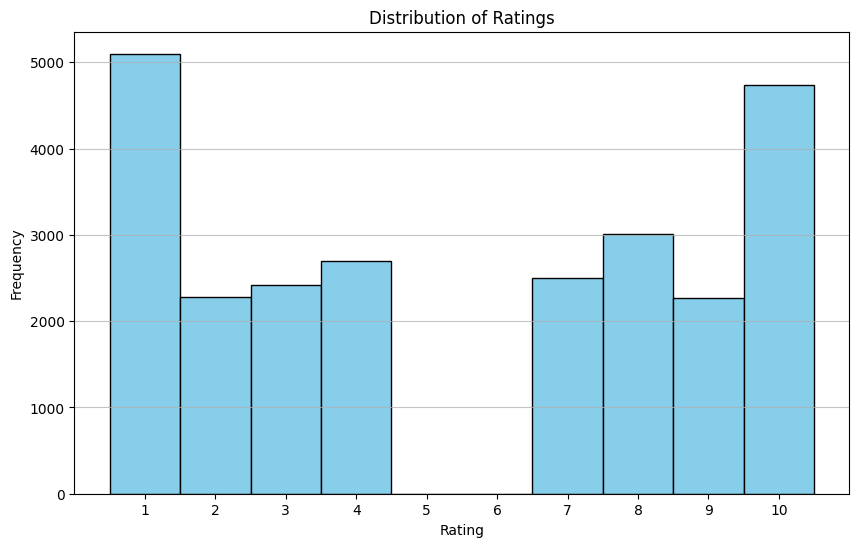

In [6]:

# The first column contains the ratings
ratings,_ = load_feat_file(os.path.join(path, 'train', 'labeledBow.feat'))

# Plot the distribution of ratings
plt.figure(figsize=(10, 6))
plt.hist(ratings, bins=range(1, 12), align='left', color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(range(1, 11))
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()

#### Load imdb.vocab to interpret feature (word) indices

In [7]:
def load_vocab_file(filepath):
  with open(filepath, 'r', encoding='UTF-8') as file:
    vocab = [line.strip() for line in file]
  return vocab

vocab = load_vocab_file(os.path.join(path, 'imdb.vocab'))
print(f'Loaded {len(vocab)} words')
print(vocab[89342:89347])

Loaded 89527 words
['divorcées', 'desando', 'maharashtrian', 'co-ordinator', 'stying']


### Filter out features

In [8]:
def count_feature_occurrences(reviews: list[dict], countOncePerReview=True):
  feat_counts = {}
  for features in reviews:
    for key in features.keys():
      if key in feat_counts:
        if countOncePerReview:
          feat_counts[key] += 1
        else:
          feat_counts[key] += features[key]
      else:
        if countOncePerReview:
          feat_counts[key] = 1
        else:
          feat_counts[key] = features[key]
  return feat_counts

def print_word_occurrences(feat_counts, vocab, word=None, feature=-1):
  index = -1
  if word is None:
    index = feature
    print(f'The word "{vocab[index]}" appears {feat_counts[index]} times')
  else:
    if isinstance(vocab, list):
      index = vocab.index(word)
    else: # assume numpy array
      index = np.where(vocab == word)[0][0]
    print(f'The word "{word}" appears {feat_counts[index]} times')

features_counts = count_feature_occurrences(labeledBow_train[1])
print(len(features_counts))
print_word_occurrences(features_counts, vocab, feature=15)
print_word_occurrences(features_counts, vocab, word='heartbreaking')

89527
The word "movie" appears 15196 times
The word "heartbreaking" appears 72 times


In [9]:
# exclude words that appear in less than 1% of the reviews, and in more than 50% of the reviews
TRAIN_REVIEWS = 25000
filtered_feats = set() # use set for O(1) lookups
excluded_feats = set()
for feat, count in features_counts.items():
  if count < (0.01 * TRAIN_REVIEWS) or count > (0.5 * TRAIN_REVIEWS):
    excluded_feats.add(feat)
  else:
    filtered_feats.add(feat)

print(f'Number of excluded features: {len(excluded_feats)}')
print(f'Number of filtered features: {len(filtered_feats)}')
print(f'First 10 excluded words: {[vocab[feat] for feat in list(excluded_feats)[:10]]}')
print(f'Filtered words: {[vocab[feat] for feat in filtered_feats]}')

Number of excluded features: 87783
Number of filtered features: 1744
First 10 excluded words: ['the', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this']
Filtered words: ['he', 'his', '!', 'by', 'an', 'who', 'they', 'from', 'so', 'like', 'there', 'her', 'or', 'just', 'about', 'if', 'has', 'out', 'what', '?', 'some', 'good', 'more', 'when', 'she', 'very', 'even', 'my', 'no', 'up', 'time', 'would', 'which', 'only', 'story', 'really', 'their', 'see', 'had', 'can', 'were', 'me', 'we', 'than', 'well', 'much', 'been', 'get', 'people', 'will', 'bad', 'other', 'also', 'into', 'do', 'because', 'great', 'first', 'how', 'him', 'most', "don't", 'its', 'made', 'then', 'them', 'way', 'make', 'could', 'too', 'any', 'after', 'movies', 'think', 'characters', 'character', 'watch', 'films', 'two', 'many', 'seen', 'being', 'acting', 'never', 'plot', 'little', 'where', 'love', 'best', 'life', 'did', 'show', 'know', 'does', 'ever', 'here', 'better', 'man', 'your', 'still', 'end', 'over', 'off', 'these', 

### Choose top features using simple linear regression

In [10]:
def simple_lin_reg(X, y):
  X_mean = np.mean(X)
  y_mean = np.mean(y)
  w1 = np.sum((X - X_mean) * (y - y_mean)) / np.sum((X - X_mean) ** 2) # coefficient
  w0 = y_mean - w1 * X_mean # intercept
  return w0, w1

def imdb_simple_lin_reg_coefficients(reviews: list[dict], ratings: list[int], filtered_feats: set[int]):
  coefficients = {} # key: feature, value: coefficient
  for feat in filtered_feats:
    # X: occurrence of word in each review, y: rating of each review
    X = np.zeros(len(reviews))
    y = np.array(ratings)
    for id in range(len(reviews)):
      if feat in reviews[id].keys():
        X[id] = reviews[id][feat]
    coefficients[feat] = simple_lin_reg(X, y)[1]
  return coefficients

In [11]:
imdb_feature_coefficients = imdb_simple_lin_reg_coefficients(labeledBow_train[1], labeledBow_train[0], filtered_feats)

In [12]:
imdb_top_100 = sorted(imdb_feature_coefficients, key=imdb_feature_coefficients.get, reverse=True)[:100]
print(f'Top 100 words with the highest coefficients: {[vocab[feat] for feat in imdb_top_100]}')
print(f'Coefficients: {[round(imdb_feature_coefficients[feat], 5) for feat in imdb_top_100]}')
print()
imdb_low_100 = sorted(imdb_feature_coefficients, key=imdb_feature_coefficients.get, reverse=False)[:100]
print(f'Low 100 words with the lowest coefficients: {[vocab[feat] for feat in imdb_low_100]}')
print(f'Coefficients: {[round(imdb_feature_coefficients[feat], 5) for feat in imdb_low_100]}')

Top 100 words with the highest coefficients: ['wonderfully', 'beautifully', 'superb', 'outstanding', 'touching', 'finest', 'delightful', 'wonderful', 'gem', 'fantastic', 'recommended', 'terrific', 'stunning', 'remarkable', 'excellent', 'perfectly', 'favorite', 'highly', 'helps', 'masterpiece', 'rare', 'subtle', 'loved', 'emotions', 'powerful', 'amazing', 'tears', 'favourite', 'brilliant', 'perfect', 'joy', 'loving', 'unique', 'tragic', 'awesome', 'gorgeous', 'deeply', 'moving', 'provides', 'quiet', 'vhs', 'greatest', 'fascinating', 'funniest', 'incredible', 'beauty', 'portrayal', 'witty', 'impressed', 'complex', 'today', 'surprising', 'intense', 'sweet', 'feelings', 'treat', 'compelling', 'memorable', 'charming', 'fresh', 'adds', 'winning', 'natural', 'journey', 'available', 'enjoyed', 'holds', 'brings', 'beautiful', 'lovely', 'unusual', 'childhood', 'solid', 'themes', 'emotional', 'unlike', 'adventure', 'appreciate', 'genius', 'nicely', 'impact', 'simple', 'won', 'performances', 'supp

In [13]:
# Sanity check that top words occur more frequently than in 1% (250) of the reviews
for i in range(3):
  print_word_occurrences(features_counts, vocab, feature=imdb_top_100[i])
print()
for i in range(3):
  print_word_occurrences(features_counts, vocab, feature=imdb_low_100[i])

The word "wonderfully" appears 311 times
The word "beautifully" appears 408 times
The word "superb" appears 621 times

The word "redeeming" appears 314 times
The word "waste" appears 1301 times
The word "laughable" appears 399 times


We can observe that the top features with the most positive simple regression coefficients indeed make sense for calling a movie good, and the top features with the most negative coefficients make sense for calling a movie bad.

In [14]:
# now sort features by absolute value of coefficients and take the top ones
IMDB_NUM_TOP_FEAT = 500
imdb_top_features = sorted(imdb_feature_coefficients, key=lambda dict_key: abs(imdb_feature_coefficients[dict_key]), reverse=True)[:IMDB_NUM_TOP_FEAT]
print(f'Top {IMDB_NUM_TOP_FEAT} words with the highest absolute coefficients: {[vocab[feat] for feat in imdb_top_features]}')
print(f'Coefficients: {[round(imdb_feature_coefficients[feat], 5) for feat in imdb_top_features]}')

imdb_top_feat = set(imdb_top_features)
print(f'Number of top features: {len(imdb_top_feat)}')

Top 500 words with the highest absolute coefficients: ['redeeming', 'waste', 'laughable', 'pointless', 'wonderfully', 'pathetic', 'garbage', 'worst', 'avoid', 'beautifully', 'wasted', 'excuse', 'superb', 'awful', 'whatsoever', 'sucks', 'poorly', 'bother', 'outstanding', 'touching', 'crap', 'finest', 'rubbish', 'lame', 'mess', 'delightful', 'worse', 'horrible', 'wonderful', 'badly', 'ridiculous', 'unless', 'wooden', 'gem', 'fantastic', 'terrible', 'recommended', 'terrific', 'stunning', 'remarkable', 'paid', 'excellent', 'painful', 'perfectly', 'sat', 'favorite', 'highly', 'stupid', 'fails', 'unbelievable', 'helps', 'masterpiece', 'trash', 'annoying', 'rare', 'subtle', 'disappointment', 'loved', 'emotions', 'powerful', 'failed', 'amazing', 'tears', 'fake', 'seconds', 'boring', 'favourite', 'brilliant', 'joke', 'blame', 'bland', 'supposed', 'mediocre', 'cheap', 'random', 'nowhere', 'perfect', 'joy', 'honestly', 'dull', 'plain', 'loving', 'rented', 'disappointing', 'unique', 'tragic', 'awe

### Build sparse matrix for training algorithms

In [15]:
def imdb_to_sparse(reviews: list[dict], filtered_feats: set[int], vocab: list[str]):
  data = []
  row = []
  col = []
  for i in range(len(reviews)):
    for feat in reviews[i].keys():
      if feat in filtered_feats:
        data.append(reviews[i][feat])
        row.append(i)
        col.append(feat)
  return coo_matrix((data, (row, col)), shape=(len(reviews), len(vocab)))

imdb_X_train = imdb_to_sparse(labeledBow_train[1], imdb_top_feat, vocab).tocsr()
imdb_X_test = imdb_to_sparse(labeledBow_test[1], imdb_top_feat, vocab).tocsr()

In [16]:
print(f'X_train shape: {imdb_X_train.shape}, X_test shape: {imdb_X_test.shape}')
print(imdb_X_train.dtype)
imdb_X_train

X_train shape: (25000, 89527), X_test shape: (25000, 89527)
int32


<25000x89527 sparse matrix of type '<class 'numpy.intc'>'
	with 362821 stored elements in Compressed Sparse Row format>

In [17]:
# print(np.where(np.array(labeledBow_train[0]) == 5))
imdb_y_train = (np.array(labeledBow_train[0]) > 5).astype(int)
imdb_y_test = (np.array(labeledBow_test[0]) > 5).astype(int)
print(imdb_y_train[:12500])
print(imdb_y_train[12500:])


[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]


## 1.2 20 news groups

### Fetch dataset

In [18]:
cats = ['comp.graphics', 'misc.forsale', 'rec.sport.baseball', 'sci.med', 'talk.politics.guns']
news_train = fetch_20newsgroups(subset='train', categories=cats, remove=('headers', 'footers', 'quotes'))
news_test = fetch_20newsgroups(subset='test', categories=cats)

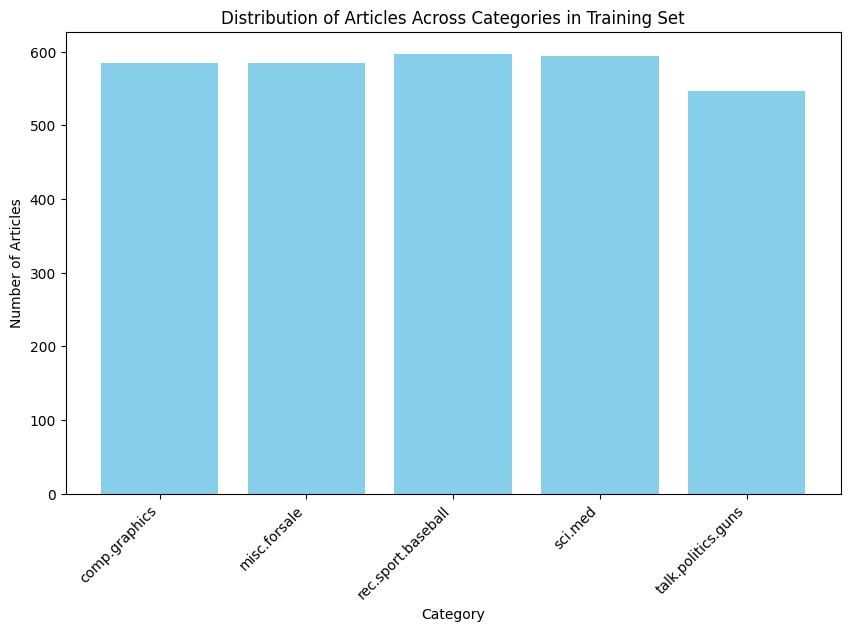

In [19]:
# Counting the number of articles in the 5 cetegory we're interested in
categories_counts = {cat: news_train.target.tolist().count(i) for i, cat in enumerate(news_train.target_names)}

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.bar(categories_counts.keys(), categories_counts.values(), color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.title('Distribution of Articles Across Categories in Training Set')
plt.xticks(rotation=45, ha='right')
plt.show()

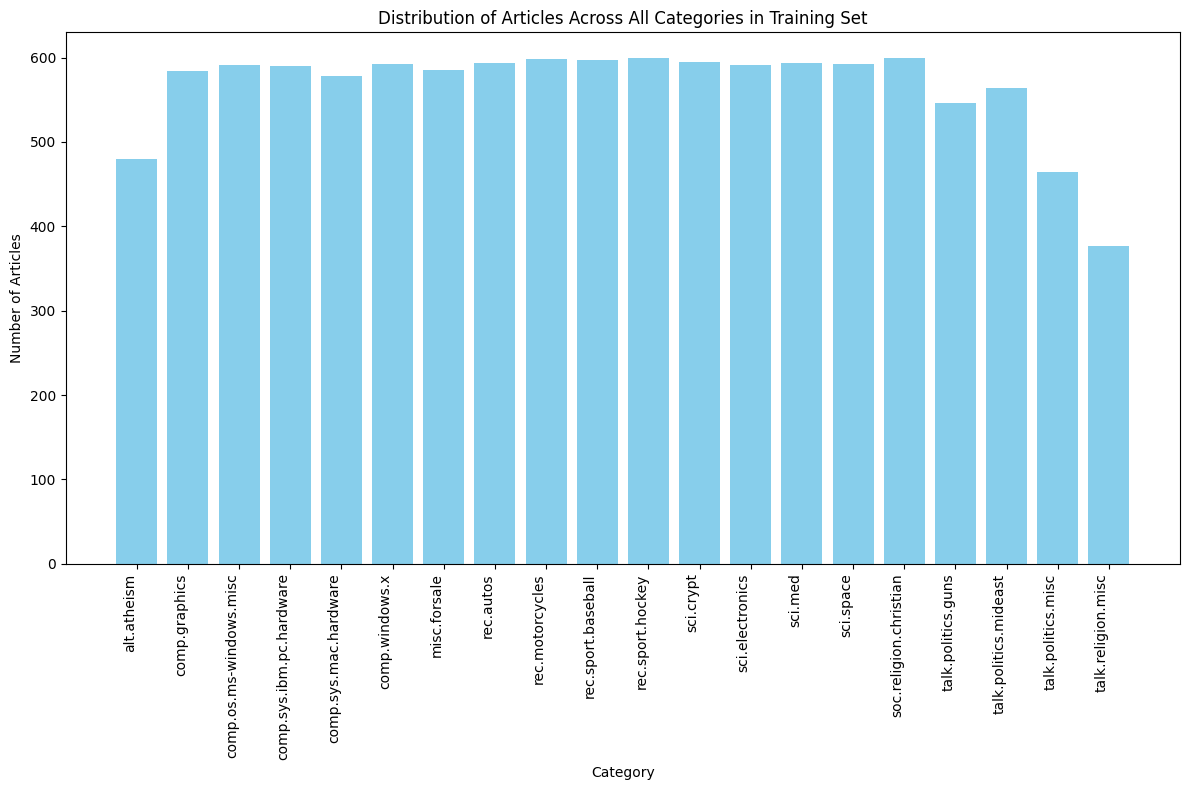

In [20]:
# Counting the number of articles in all category
news_train_all = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
categories_counts_all = {cat: news_train_all.target.tolist().count(i) for i, cat in enumerate(news_train_all.target_names)}

# Plotting the distribution
plt.figure(figsize=(12, 8))
plt.bar(categories_counts_all.keys(), categories_counts_all.values(), color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.title('Distribution of Articles Across All Categories in Training Set')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# This line is necessary to display the plot when running the code in a local Python script or a Jupyter notebook.
plt.show()

In [21]:
print(news_train.target_names)
print(news_train.target.shape)
print(news_test.target.shape)

['comp.graphics', 'misc.forsale', 'rec.sport.baseball', 'sci.med', 'talk.politics.guns']
(2906,)
(1936,)


### Vectorize

In [22]:
# exclude words that appear in less than 0.5% of the news, and in more than 30% of the news during the vectorization
NEWS_MIN_DF = 0.005
NEWS_MAX_DF = 0.3

In [23]:
vectorizer = TfidfVectorizer(min_df=NEWS_MIN_DF, max_df=NEWS_MAX_DF, stop_words='english')
vectors_train = vectorizer.fit_transform(news_train.data)
vectors_test = vectorizer.transform(news_test.data)
news_vocab = vectorizer.get_feature_names_out()
print(f'Class: {type(vectors_train)}', vectors_train.shape)
print(f'Class: {type(vectors_test)}', vectors_test.shape)
vectors_train

# print('How to get nonzero column indices in sparse matrix:\n', vectors_train[2].nonzero()[1])
# print(vectors_train[2, vectors_train[2].nonzero()[1][0]])
# print(news_vocab[vectors_train[2].nonzero()[1][0]])

Class: <class 'scipy.sparse._csr.csr_matrix'> (2906, 2340)
Class: <class 'scipy.sparse._csr.csr_matrix'> (1936, 2340)


<2906x2340 sparse matrix of type '<class 'numpy.float64'>'
	with 102059 stored elements in Compressed Sparse Row format>

In [24]:
c_vectorizer = CountVectorizer(min_df=NEWS_MIN_DF, max_df=NEWS_MAX_DF, stop_words='english')
c_vectors_train = c_vectorizer.fit_transform(news_train.data)
c_vectors_test = c_vectorizer.transform(news_test.data)
print(f'Class: {type(c_vectors_train)}', c_vectors_train.shape)
print(f'Class: {type(c_vectors_test)}', c_vectors_test.shape)
c_vectors_train

Class: <class 'scipy.sparse._csr.csr_matrix'> (2906, 2340)
Class: <class 'scipy.sparse._csr.csr_matrix'> (1936, 2340)


<2906x2340 sparse matrix of type '<class 'numpy.int64'>'
	with 102059 stored elements in Compressed Sparse Row format>

### Filter out features

In [25]:
def news_count_occurrences(feat_vectors: csr_matrix):
  # count in how many rows did a feature appear
  feat_counts = {}
  for row in feat_vectors:
    for col in row.nonzero()[1]:
      if col in feat_counts:
        feat_counts[col] += 1
      else:
        feat_counts[col] = 1
  return feat_counts

In [26]:
news_feat_counts = news_count_occurrences(vectors_train)
print(len(news_feat_counts))
print_word_occurrences(news_feat_counts, news_vocab, feature=0)
print_word_occurrences(news_feat_counts, news_vocab, word='gordon')

2340
The word "00" appears 111 times
The word "gordon" appears 92 times


In [27]:
# this shouldn't exclude any new values since we already filtered the features during vectorization: test if filter during vectorization is successful
NEWS_COUNT = len(news_train.target)
news_filtered_feats = set() # use set for O(1) lookups
news_excluded_feats = set()
for feat, count in news_feat_counts.items():
  if count < (NEWS_MIN_DF * NEWS_COUNT) or count > (NEWS_MAX_DF * NEWS_COUNT):
    news_excluded_feats.add(feat)
  else:
    news_filtered_feats.add(feat)

print(f'Number of excluded features: {len(news_excluded_feats)}')
print(f'Number of filtered features: {len(news_filtered_feats)}')
print(f'First 10 excluded words: {[news_vocab[feat] for feat in list(news_excluded_feats)[:10]]}')
print(f'Filtered words: {[news_vocab[feat] for feat in news_filtered_feats]}')

Number of excluded features: 0
Number of filtered features: 2340
First 10 excluded words: []
Filtered words: ['00', '000', '01', '03', '04', '05', '10', '100', '1000', '101', '11', '110', '12', '120', '1200', '125', '128', '129', '13', '130', '14', '149', '15', '150', '16', '160', '17', '175', '18', '19', '1968', '1980', '1982', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1st', '20', '200', '21', '22', '225', '23', '24', '2400', '25', '250', '256', '26', '27', '275', '28', '286', '29', '2b', '2d', '2nd', '30', '300', '31', '312', '32', '320', '33', '34', '35', '350', '36', '360', '37', '38', '386', '39', '3d', '3rd', '40', '400', '408', '41', '415', '42', '43', '44', '45', '46', '47', '48', '486', '49', '4th', '50', '500', '51', '52', '54', '55', '56', '57', '58', '59', '60', '600', '61', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '75', '750', '77', '78', '79', '80', '800', '81', '84', '85', '86', '87', '88', '89', '90', '91', '92', '

In [28]:
def filter_feature_vector(feat_vectors: csr_matrix, filtered_feats: set[int]):
  filter_columns = np.zeros(feat_vectors.shape[1])
  filter_columns[list(filtered_feats)] = 1 # set to 1 if feature is included
  filter_matrix = diags(filter_columns, dtype = feat_vectors.dtype) # create a diagonal matrix with the filter_columns as the diagonal
  # print(filter_matrix.A)
  res = feat_vectors @ filter_matrix # matrix multiplication
  res.eliminate_zeros() # remove zero entries
  return res

In [29]:
vectors_train_filtered = filter_feature_vector(vectors_train, news_filtered_feats)
c_vectors_train_filtered = filter_feature_vector(c_vectors_train, news_filtered_feats)
print(f'Class: {type(vectors_train_filtered)}', vectors_train_filtered.shape)
vectors_train_filtered

Class: <class 'scipy.sparse._csr.csr_matrix'> (2906, 2340)


<2906x2340 sparse matrix of type '<class 'numpy.float64'>'
	with 102059 stored elements in Compressed Sparse Row format>

### Choose top features using mutual information

In [30]:
# unused function since sklearn.feature_selection.mutual_info_classif does the same thing but faster
def news_mi(feat_vectors: csr_matrix, y: np.ndarray, filtered_feats: set):
  mi_scores = {} # key: feature, value: mi
  for feat in filtered_feats:
    # X: value of feat in each row, y: ground truth of each row
    X = np.zeros(feat_vectors.shape[0])
    for id in range(feat_vectors.shape[0]):
      if feat in feat_vectors[id].nonzero()[1]: # if feature is present in the row of sparse matrix
        X[id] = feat_vectors[id, feat]
    mi_scores[feat] = mutual_info_score(y, X)
  return mi_scores

In [31]:
news_cat_mi_scores = []
news_cat_top_100 = []
for id, cat in enumerate(news_train.target_names):
  print(f'Category: {cat}')
  cat_target = (news_train.target == id).astype(int) # 1 if the category is the current category, 0 otherwise
  cat_mi_scores = mutual_info_classif(c_vectors_train_filtered, cat_target, random_state=42)
  cat_mi_scores = {feat: mi for feat, mi in enumerate(cat_mi_scores)}
  cat_top_100 = sorted(cat_mi_scores, key=cat_mi_scores.get, reverse=True)[:100]
  news_cat_mi_scores.append(cat_mi_scores)
  news_cat_top_100.append(cat_top_100)
  print(f'Top 100 words with the highest MI scores: {[news_vocab[feat] for feat in cat_top_100]}')
  print(f'MI scores: {[round(cat_mi_scores[feat], 5) for feat in cat_top_100]}')
  print()

Category: comp.graphics
Top 100 words with the highest MI scores: ['graphics', 'files', 'image', 'program', 'file', '3d', 'ftp', 'code', 'images', 'format', 'thanks', 'sale', 'gif', 'algorithm', 'hi', 'animation', 'people', 'programs', 'gun', 'advance', 'polygon', 'screen', 'convert', 'directory', 'software', 'formats', 'computer', 'tiff', 'hardware', 'year', 'programming', 'colors', 'algorithms', 'vga', '256', 'windows', 'pov', 'version', 'comp', 'color', 'help', 'mode', 'mac', 'jpeg', 'using', 'site', 'pixel', 'object', 'unix', 'video', 'package', 'sphere', 'guns', 'pub', 'baseball', 'surface', 'condition', 'points', 'routines', 'interface', 'available', 'write', 'appreciated', 'sgi', 'virtual', 'vesa', 'dos', 'viewer', 'pc', 'display', 'pcx', 'library', 'new', 'ray', 'visualization', 'sites', 'weapons', 'map', 'drawing', 'bit', 'years', 'shareware', 'need', 'anonymous', 'team', 'postscript', 'edu', 'banks', 'systems', 'game', 'government', '2d', 'games', 'line', 'surrender', 'season

In [32]:
news_mi_feats = set()
for cat_top_100 in news_cat_top_100:
  for feat in cat_top_100[:80]:
    news_mi_feats.add(feat)

print([news_vocab[feat] for feat in news_mi_feats])
print(f'Total selected features: {len(news_mi_feats)}')

['00', 'suicide', '10', '100', 'surface', 'surgery', 'surrender', '15', '150', 'symptoms', 'syndrome', 'talent', 'tanks', 'tape', '20', 'team', 'teams', '25', '250', '256', '30', '300', 'tests', 'thanks', 'therapy', 'think', '3d', 'tiff', '50', 'toronto', 'treating', 'treatment', 'treatments', 'twins', 'aaa', 'abiding', 'unit', 'unix', 'use', 'using', 'usually', 'advance', 'version', 'vesa', 'vga', 'video', 'agents', 'viewer', 'violent', 'virtual', 'algorithm', 'algorithms', 'visualization', 'allergic', 'alomar', 'waco', 'amendment', 'animation', 'weapon', 'weapons', 'appreciated', 'win', 'windows', 'winning', 'wins', 'armed', 'arms', 'asking', 'assault', 'atf', 'write', 'yankees', 'year', 'yeast', 'available', 'average', 'ball', 'ban', 'banks', 'baseball', 'batf', 'batting', 'bd', 'bear', 'believe', 'better', 'bit', 'blood', 'boston', 'box', 'brand', 'braves', 'bullpen', 'buyer', 'cable', 'cadre', 'cancer', 'card', 'career', 'carry', 'cassette', 'catcher', 'cause', 'causes', 'cd', 'ch

In [33]:
vectors_train_filtered = filter_feature_vector(vectors_train, news_mi_feats)
c_vectors_train_filtered = filter_feature_vector(c_vectors_train, news_mi_feats)
vectors_train_filtered

<2906x2340 sparse matrix of type '<class 'numpy.float64'>'
	with 24838 stored elements in Compressed Sparse Row format>

In [34]:
# we need to convert targets to one-hot encoding for fitting
def to_onehot(y, nClasses):
    return np.eye(nClasses)[y]

news_y_labels = news_train.target_names

news_X_train = vectors_train_filtered
news_y_train = news_train.target
news_y_train_onehot = to_onehot(news_y_train, len(news_y_labels))

news_X_test = vectors_test
news_y_test = news_test.target

# 2. Task 2: Implement logistic and multiclass classifiers

## Logistic regression on IMDB data

### Logistic regression class

In [35]:
logistic = lambda x: 1 / (1 + np.exp(-x))

# Logistic Regression from tutorial, modified to use sparse matrices
class LogisticRegressionTut:

    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(x.dot(self.w))        # predictions size N
        grad = x.T.dot(yh - y) / N          # divide by N because cost is mean over N points
        return grad

    def ce(self, X, y):
        a = X.dot(self.w)
        return np.mean(y * np.log1p(np.exp(-a)) + (1 - y) * np.log1p(np.exp(a))) # divide by N because loss is mean over N points

    def fit(self, x, y, x_valid=None, y_valid=None):
        losses_train = np.zeros(self.max_iters)
        losses_valid = np.zeros(self.max_iters)

        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            # x = np.column_stack([x,np.ones(N)])
            x = hstack([x, csr_matrix(np.ones(N)).T], format='csr')
            if x_valid is not None:
                x_valid = hstack([x_valid, csr_matrix(np.ones(x_valid.shape[0])).T], format='csr')
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g

            # compute cross entropy loss
            losses_train[t] = self.ce(x, y)
            if x_valid is not None and y_valid is not None:
                losses_valid[t] = self.ce(x_valid, y_valid)
                if self.verbose:
                    print(f'iteration {t}, train loss: {losses_train[t]}, valid loss: {losses_valid[t]}')
            else:
                if self.verbose:
                    print(f'iteration {t}, train loss: {losses_train[t]}')

            t += 1

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')

        return losses_train[:t], losses_valid[:t]

    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            # x = np.column_stack([x,np.ones(Nt)])
            x = hstack([x, csr_matrix(np.ones(Nt)).T], format='csr')
        yh = logistic(x.dot(self.w))            #predict output
        return yh

    def coefficients(self):
        return self.w[:-1]

    def check_grad(self, X, y):
        if self.add_bias:
            N = X.shape[0]
            X = hstack([X, csr_matrix(np.ones(N)).T], format='csr')
        N, D = X.shape
        diff = np.zeros(D)
        self.w = np.random.rand((D))
        W = self.w.copy()
        for i in range(D):
            epsilon = np.zeros(D)
            epsilon[i] = np.random.rand() * 1e-4

            self.w = self.w + epsilon
            ce1 = self.ce(X, y)
            self.w = W

            self.w = self.w - epsilon
            ce2 = self.ce(X, y)
            self.w = W

            numeric_grad = (ce1 - ce2) / (2 * epsilon[i])
            derived_grad = self.gradient(X, y)[i]

            diff[i] = np.square((derived_grad - numeric_grad)) / np.square((derived_grad + numeric_grad))

        return diff.sum()


### Check gradient using small perturbation

In [36]:
def log_reg_check_gradient():
  x = csr_matrix(np.matrix([[0.02, 0.03, 0, 0, 0], [0.05, 0.03, 0, 0, 0.01], [0, 0.01, 0.05, 0.06, 0.02]]))
  y = np.array([1, 1, 0])
  lin_reg = LogisticRegressionTut()
  print(lin_reg.check_grad(x, y))

log_reg_check_gradient()

1.8563449802854572e-18


Since the difference between the analytical method (the exact calculation used in our logistic regression implementation) is very close to the gradient estimated through small perturbations, this indicates that our gradient computation is correct.

### Monitor cross-entropy

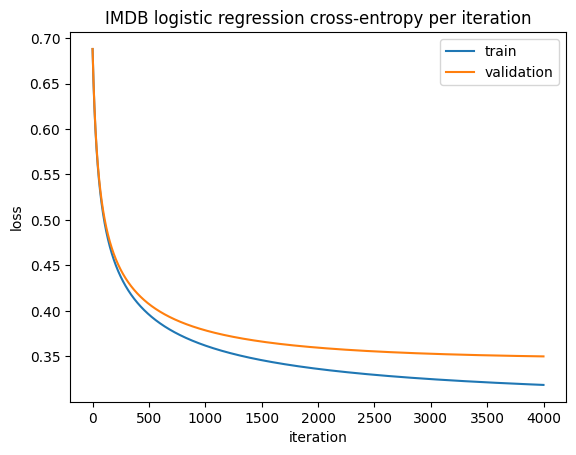

In [37]:
imdb_log_reg = LogisticRegressionTut(learning_rate=0.1, max_iters=4000, verbose=False)

def train_log_reg():
  X_train, X_valid, y_train, y_valid = model_selection.train_test_split(imdb_X_train, imdb_y_train, test_size=0.5, random_state=42)
  train_loss, validation_loss = imdb_log_reg.fit(X_train, y_train, X_valid, y_valid)
  return train_loss, validation_loss

def imdb_plot_ce(train_loss, valid_loss):
  plt.plot(train_loss, label='train')
  plt.plot(valid_loss, label='validation')
  plt.xlabel('iteration')
  plt.ylabel('loss')
  plt.title('IMDB logistic regression cross-entropy per iteration')
  plt.legend()

imdb_log_reg_losses_train, imdb_log_reg_losses_valid = train_log_reg()
imdb_plot_ce(imdb_log_reg_losses_train, imdb_log_reg_losses_valid)

In the plot above, we observe that both the training and validation cross-entropy curves continue to decrease, showing no sign of overfitting.

### Evaluating ROC and AUROC

In [38]:
imdb_log_reg_pred_probs = imdb_log_reg.predict(imdb_X_test) # get probabilities of being in class 1
imdb_log_reg_pred = np.array([1 if i > 0.5 else 0 for i in imdb_log_reg_pred_probs]) # convert probabilities to hard predictions
print(f'Classification accuracy of Logistic Regression: {np.mean(imdb_log_reg_pred == imdb_y_test) * 100}%')

imdb_log_reg_coef = imdb_log_reg.coefficients()
print(f'Number of non-zero coefficients: {imdb_log_reg_coef.nonzero()[0].shape[0]}')
print(f'{np.sum(imdb_log_reg_coef.nonzero()[0] == sorted(list(imdb_top_feat)))} of the non-zero coefficients are in the top features list, which has {len(imdb_top_feat)} features.')

imdb_log_reg_top_abs = np.flip(np.argsort(np.absolute(imdb_log_reg_coef))) # sort features by absolute value
print('Top 20 absolute features:', [vocab[feat] for feat in imdb_log_reg_top_abs[:20]])
print('Top 20 absolute coefficients:', [round(imdb_log_reg_coef[feat], 6) for feat in imdb_log_reg_top_abs[:20]])

Classification accuracy of Logistic Regression: 85.60799999999999%
Number of non-zero coefficients: 500
500 of the non-zero coefficients are in the top features list, which has 500 features.
Top 20 absolute features: ['waste', 'worst', 'awful', 'excellent', 'favorite', 'worse', 'boring', 'terrible', 'poor', 'perfect', 'poorly', 'dull', 'disappointing', 'annoying', 'horrible', 'superb', 'amazing', 'unfortunately', 'mess', 'disappointment']
Top 20 absolute coefficients: [-1.372368, -1.365595, -1.085806, 1.030564, 0.877283, -0.865281, -0.850743, -0.822958, -0.8064, 0.80521, -0.801392, -0.798549, -0.792232, -0.741323, -0.727497, 0.712437, 0.710499, -0.700577, -0.697656, -0.694521]


In [39]:
imdb_dt_clf = DecisionTreeClassifier(random_state=42)
imdb_dt_clf.fit(imdb_X_train, imdb_y_train)
imdb_dt_pred = imdb_dt_clf.predict(imdb_X_test)
print(f'Classification accuracy of Decision Tree: {np.mean(imdb_dt_pred == imdb_y_test) * 100}%')

Classification accuracy of Decision Tree: 72.432%


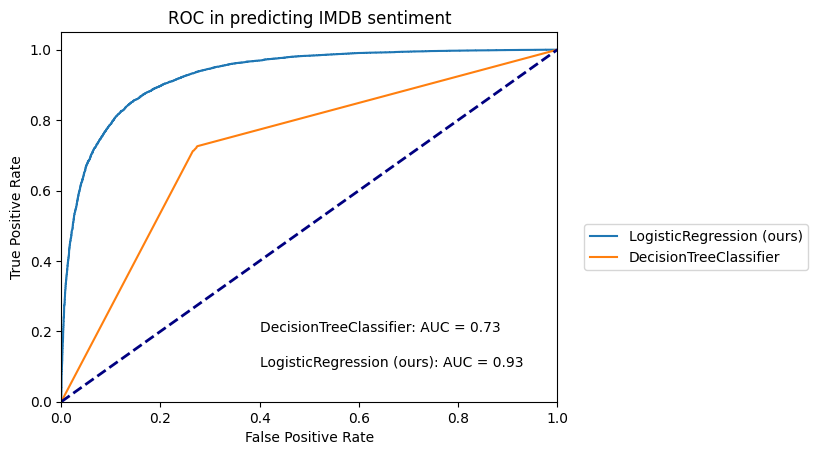

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

X_train, y_train, X_test, y_test = imdb_X_train, imdb_y_train, imdb_X_test, imdb_y_test

models = [DecisionTreeClassifier()]

perf = {}

# our implementation is slow you may try sklearn version
logitreg = LogisticRegressionTut(max_iters=2000)
logitreg.fit(X_train, y_train)
y_test_prob = logitreg.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
auroc = roc_auc_score(y_test, y_test_prob)
perf["LogisticRegression (ours)"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}

for model in models:
    fit = model.fit(X_train, y_train)
    y_test_prob = fit.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    auroc = roc_auc_score(y_test, y_test_prob)
    if type(model).__name__ == "LogisticRegression":
        perf["LogisticRegression (sklearn)"] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
    else:
        perf[type(model).__name__] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}

def imdb_plot_roc():
    plt.clf()
    i = 0
    for model_name, model_perf in perf.items():
        plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
        plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
        i += 0.1

    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title('ROC in predicting IMDB sentiment')
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
    plt.show()
    plt.close()

imdb_plot_roc()

## Multiclass regression on the 5-class prediction from the 20-news-group data

### Multiclass regression class

In [41]:
# Multiclass regression from tutorial, modified to use sparse matrices
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        # y_pred = np.exp(np.matmul(X, self.W))
        y_pred = np.exp(X @ self.W)
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        # return np.matmul(X.transpose(), self.predict(X) - y)
        return X.T @ (self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    # modify it to add stopping criteria (what can you think of?)
    def fit(self, X, y, X_valid=None, y_valid=None, learning_rate=0.005, niter=100, verbose=False):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - learning_rate * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                if verbose:
                    print(f"iter {i} loss: {loss_train:.3f}; {loss_valid:.3f}")
            else:
                if verbose:
                    print(f"iter {i} loss: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()

    def coefficients(self):
        return self.W

### Check gradient using small perturbation

In [42]:
def multi_reg_check_gradient():
  N = 150
  X = np.column_stack((np.random.binomial(1, 0.5, N),
                       np.random.binomial(1, 0.5, N),
                       np.random.binomial(1, 0.5, N),
                       np.random.binomial(1, 0.5, N)))
  W_true = np.array([[0,1,0],
                    [0,0,1],
                    [1,0,0],
                    [0,0,1]])
  a = np.matmul(X, W_true)
  y = np.zeros_like(a)
  y[np.arange(len(a)), a.argmax(1)] = 1
  multi_reg = Multinomial_logistic(X.shape[1], y.shape[1])
  print(multi_reg.check_grad(X, y))

multi_reg_check_gradient()

4.365757415586959e-19


Similarly as gradient checking using small perturbation as the above logistic regression implementation, since the difference between the analytical method (the exact calculation used in our multiclass regression implementation) is very close to the gradient estimated through small perturbations, this indicates that our gradient computation is correct.

### Monitor cross-entropy

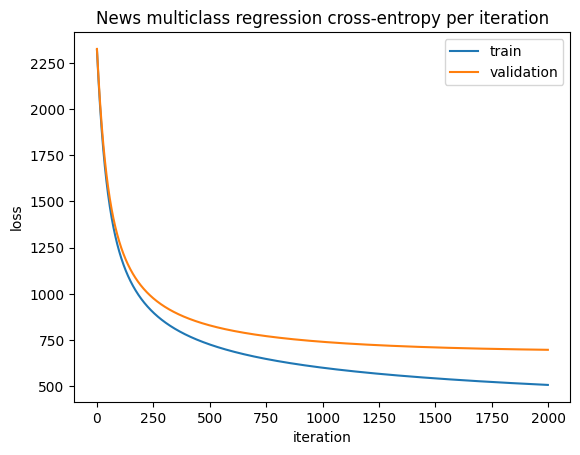

In [43]:
news_multi_reg = Multinomial_logistic(news_X_train.shape[1], len(news_y_labels))

def train_multi_reg():
  X_train, X_valid, y_train, y_valid = model_selection.train_test_split(news_X_train, news_y_train_onehot, test_size=0.5, random_state=42)
  news_multi_reg_losses_train, news_multi_reg_losses_valid = news_multi_reg.fit(X_train, y_train, X_valid, y_valid, learning_rate=0.005, niter=2000)
  return news_multi_reg_losses_train, news_multi_reg_losses_valid

def news_plot_ce(train_loss, valid_loss):
  plt.plot(train_loss, label='train')
  plt.plot(valid_loss, label='validation')
  plt.xlabel('iteration')
  plt.ylabel('loss')
  plt.title('News multiclass regression cross-entropy per iteration')
  plt.legend()

news_multi_reg_losses_train, news_multi_reg_losses_valid = train_multi_reg()
news_plot_ce(news_multi_reg_losses_train, news_multi_reg_losses_valid)

In the plot above, we observe that both the training and validation cross-entropy curves continue to decrease, showing no sign of overfitting.

### Evaluating classification accuracy

In [44]:
news_multi_reg_pred_probs = news_multi_reg.predict(news_X_test)
news_multi_reg_pred = np.argmax(news_multi_reg_pred_probs, axis=1)
print(f'Classification accuracy of Multiclass Regression: {np.mean(news_multi_reg_pred == news_y_test) * 100:.3f}%')

Classification accuracy of Multiclass Regression: 87.448%


In [45]:
news_df_clf = DecisionTreeClassifier(random_state=42)
news_df_clf.fit(news_X_train, news_y_train)
news_df_pred = news_df_clf.predict(news_X_test)
print(f'Classification accuracy of Decision Tree: {np.mean(news_df_pred == news_y_test) * 100:.3f}%')

Classification accuracy of Decision Tree: 77.014%


# 3. Task 3: Run experiments - Report charts

## Plot 1: Top 20 features from simple linear regression on IMDB data

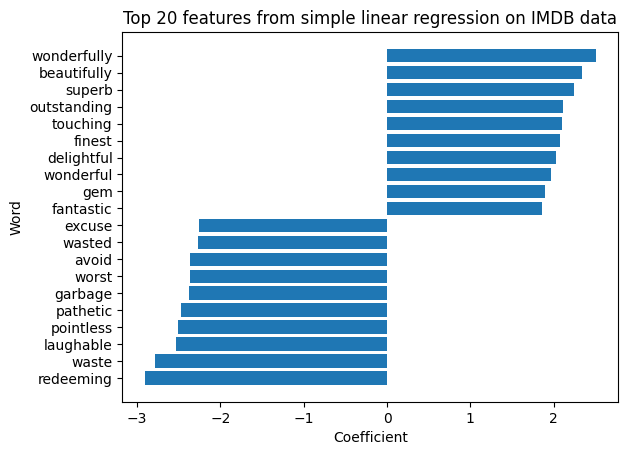

In [46]:
def imdb_plot_1():
  words = [vocab[feat] for feat in imdb_low_100[:10]] + [vocab[feat] for feat in imdb_top_100[:10]][::-1]
  coefs = [imdb_feature_coefficients[feat] for feat in imdb_low_100[:10]] + [imdb_feature_coefficients[feat] for feat in imdb_top_100[:10]][::-1]
  plt.barh(words, coefs)
  plt.xlabel('Coefficient')
  plt.ylabel('Word')
  plt.title('Top 20 features from simple linear regression on IMDB data')
  plt.show()

imdb_plot_1()

## Plot 2a: Convergence of logistic regression

See task 2 for more details

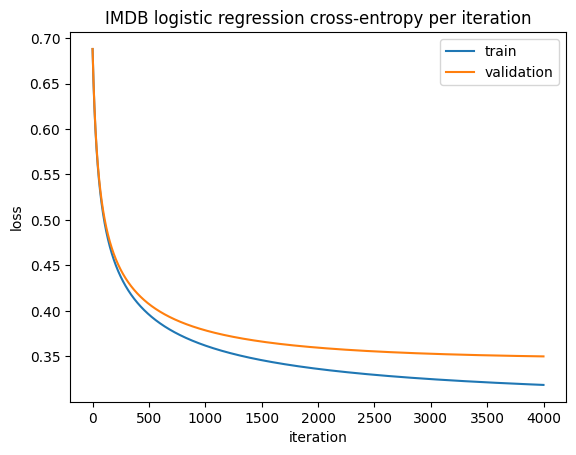

In [47]:
imdb_plot_ce(imdb_log_reg_losses_train, imdb_log_reg_losses_valid)

## Plot 2b: Convergeance of multiclass regression

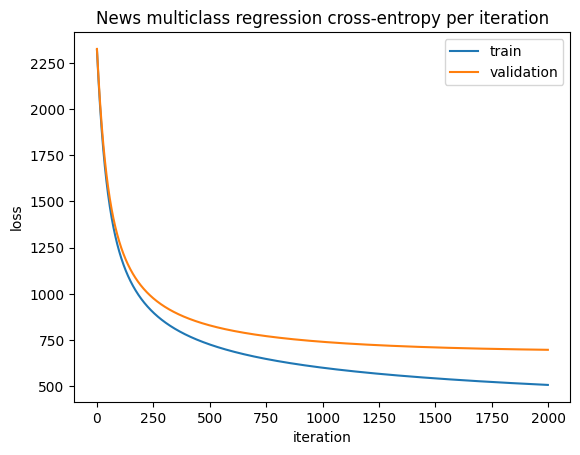

In [48]:
news_plot_ce(news_multi_reg_losses_train, news_multi_reg_losses_valid)

## Plot 3: ROC of logistic regression and sk-learn decision trees on IMDB data

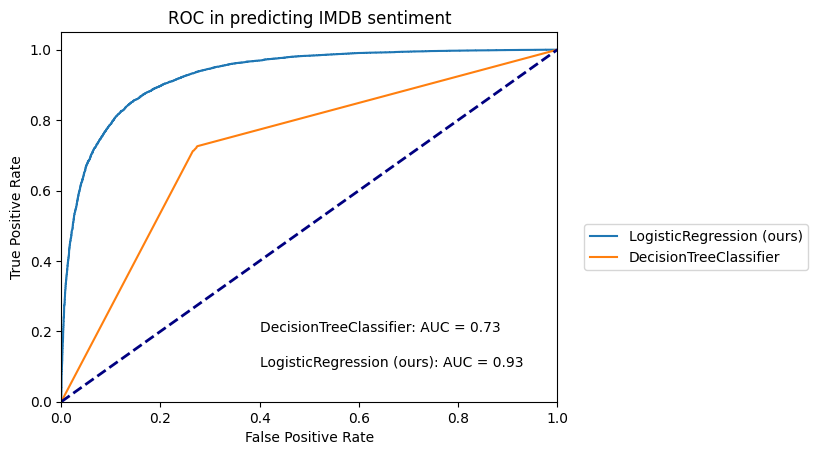

In [49]:
imdb_plot_roc()

## Plot 4: AUROC of logistic regression and DT in function of training data size

In [50]:
def plot_4():
  sizes = [0.2, 0.4, 0.6, 0.8, 1.0]
  auroc_lr = []
  auroc_dt = []
  for size in sizes:
    X_train = imdb_X_train
    y_train = imdb_y_train
    if size != 1.0:
      _, X_train, _, y_train = model_selection.train_test_split(imdb_X_train, imdb_y_train, test_size=size, random_state=42)
    imdb_log_reg = LogisticRegressionTut(learning_rate=0.1, max_iters=4000, verbose=False)
    imdb_log_reg.fit(X_train, y_train)
    imdb_log_reg_pred_probs = imdb_log_reg.predict(imdb_X_test)
    imdb_log_reg_pred = np.array([1 if i > 0.5 else 0 for i in imdb_log_reg_pred_probs])
    auroc_lr.append(roc_auc_score(imdb_y_test, imdb_log_reg_pred))

    imdb_dt_clf = DecisionTreeClassifier(random_state=42)
    imdb_dt_clf.fit(X_train, y_train)
    imdb_dt_pred = imdb_dt_clf.predict(imdb_X_test)
    auroc_dt.append(roc_auc_score(imdb_y_test, imdb_dt_pred))
  return auroc_lr, auroc_dt

plot_4_lr, plot_4_dt = plot_4()

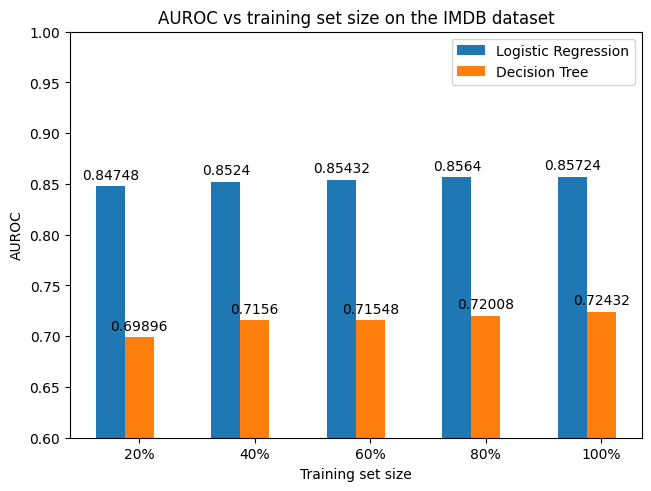

In [51]:
def plot_4_plot(auroc_lr, auroc_dt):
  labels = ['20%', '40%', '60%', '80%', '100%']
  x = np.arange(len(labels))
  width = 0.25
  fig, ax = plt.subplots(layout='constrained')
  rects = ax.bar(x, auroc_lr, width, label='Logistic Regression')
  ax.bar_label(rects, padding=3)
  rects2 = ax.bar(x + width, auroc_dt, width, label='Decision Tree')
  ax.bar_label(rects2, padding=3)

  ax.set_ylabel('AUROC')
  ax.set_xlabel('Training set size')
  ax.set_xticks(x + width, labels)
  ax.legend()
  ax.set_title('AUROC vs training set size on the IMDB dataset')
  ax.set_ylim(0.6, 1.0)

plot_4_plot(plot_4_lr, plot_4_dt)

## Plot 5: Classification accuracies of multiclass regression and DT in function of training data size

In [52]:
def plot_5():
  sizes = [0.2, 0.4, 0.6, 0.8, 1.0]
  acc_multi = []
  acc_dt = []
  for size in sizes:
    X_train = news_X_train
    y_train = news_y_train
    if size != 1.0:
      _, X_train, _, y_train = model_selection.train_test_split(news_X_train, news_y_train, test_size=size, random_state=42)
    news_multi_reg = Multinomial_logistic(X_train.shape[1], len(news_y_labels))
    news_multi_reg.fit(X_train, to_onehot(y_train, len(news_y_labels)), learning_rate=0.005, niter=2000)
    news_multi_reg_pred_probs = news_multi_reg.predict(news_X_test)
    news_multi_reg_pred = np.argmax(news_multi_reg_pred_probs, axis=1)
    acc_multi.append(np.mean(news_multi_reg_pred == news_y_test))

    news_df_clf = DecisionTreeClassifier(random_state=42)
    news_df_clf.fit(X_train, y_train)
    news_df_pred = news_df_clf.predict(news_X_test)
    acc_dt.append(np.mean(news_df_pred == news_y_test))
  return acc_multi, acc_dt

plot_5_multi, plot_5_dt = plot_5()

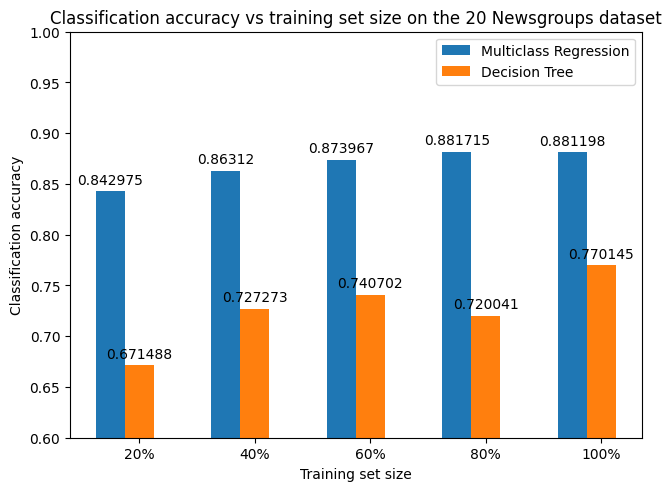

In [53]:
def plot_5_plot(acc_multi, acc_dt):
  labels = ['20%', '40%', '60%', '80%', '100%']
  x = np.arange(len(labels))
  width = 0.25
  fig, ax = plt.subplots(layout='constrained')
  rects = ax.bar(x, acc_multi, width, label='Multiclass Regression')
  ax.bar_label(rects, padding=3)
  rects2 = ax.bar(x + width, acc_dt, width, label='Decision Tree')
  ax.bar_label(rects2, padding=3)

  ax.set_ylabel('Classification accuracy')
  ax.set_xlabel('Training set size')
  ax.set_xticks(x + width, labels)
  ax.legend()
  ax.set_title('Classification accuracy vs training set size on the 20 Newsgroups dataset')
  ax.set_ylim(0.6, 1.0)

plot_5_plot(plot_5_multi, plot_5_dt)

## Plot 6: Top 20 features from logistic regression on IMDB data

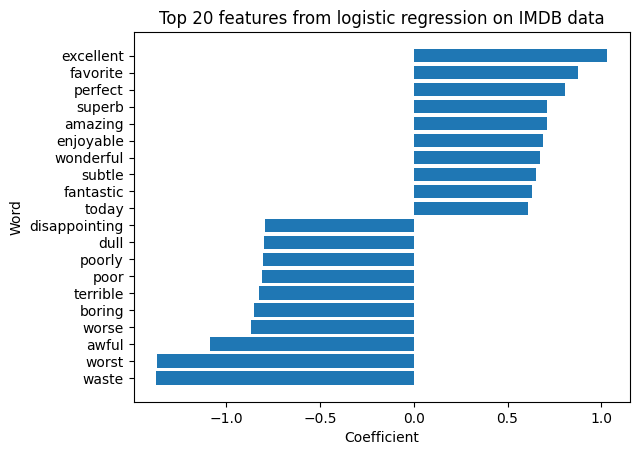

In [54]:
def imdb_plot_6():
  imdb_top_10 = np.flip(np.argsort(imdb_log_reg_coef))[:10]
  imdb_low_10 = np.argsort(imdb_log_reg_coef)[:10]
  words = [vocab[feat] for feat in imdb_low_10] + [vocab[feat] for feat in imdb_top_10][::-1]
  coefs = [imdb_log_reg_coef[feat] for feat in imdb_low_10] + [imdb_log_reg_coef[feat] for feat in imdb_top_10][::-1]
  plt.barh(words, coefs)
  plt.xlabel('Coefficient')
  plt.ylabel('Word')
  plt.title('Top 20 features from logistic regression on IMDB data')
  plt.show()

imdb_plot_6()

## Plot 7: Top 5 features for each class from nulti-class classification on News data

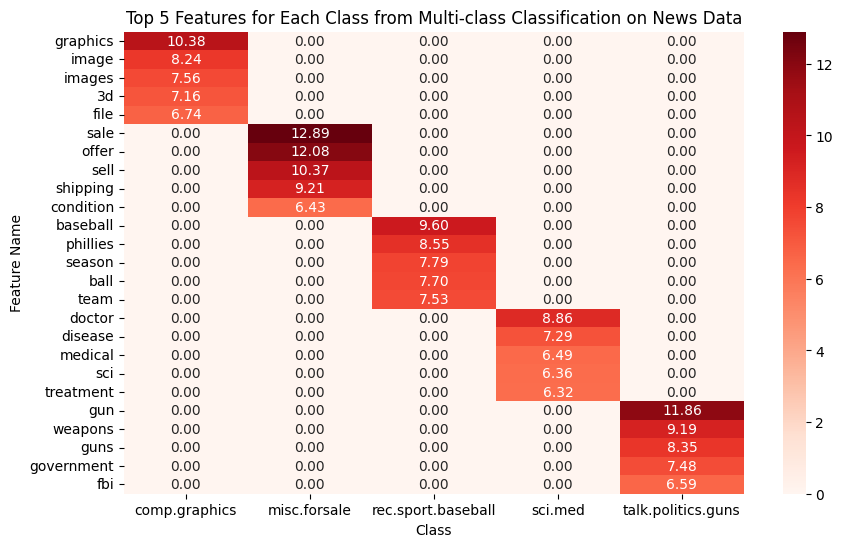

In [55]:
def plot_7(news_multi_reg, cats):
    W_hat = news_multi_reg.W


    # Find the top 5 features for each class
    top_features_indices = []
    top_features_coefficients = []

    for class_idx in range(5):
        top_indices = np.argsort(W_hat[:, class_idx])[::-1][:5]
        top_features_indices.extend(top_indices)
        top_features_coefficients.extend(W_hat[top_indices, class_idx])

    # Output the indices and coefficients of the top features for each class
    for idx in range(25):
        feature_index = top_features_indices[idx]
        coefficient = top_features_coefficients[idx]
        feature_name = news_vocab[feature_index]
        class_name = cats[idx // 5]
        # print(f"Class: {class_name}, Feature {idx % 5 + 1}: Index - {feature_index}, Coefficient - {coefficient}, Feature Name - {feature_name}")

    # Create an empty matrix to store the results
    result_matrix = np.zeros((25, 5))

    # Fill the matrix with coefficients where applicable
    for idx in range(25):
        feature_index = top_features_indices[idx]
        coefficient = top_features_coefficients[idx]
        result_matrix[idx, idx // 5] = coefficient

    # Plot a heatmap of the result matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(result_matrix, annot=True, fmt=".2f", xticklabels=cats, yticklabels=[news_vocab[i] for i in top_features_indices], cmap='Reds')
    plt.xlabel('Class')
    plt.ylabel('Feature Name')
    plt.title('Top 5 Features for Each Class from Multi-class Classification on News Data')
    plt.show()
plot_7(news_multi_reg, cats)

# Creativity

## 1. Explore different learning rates for multi-class regression

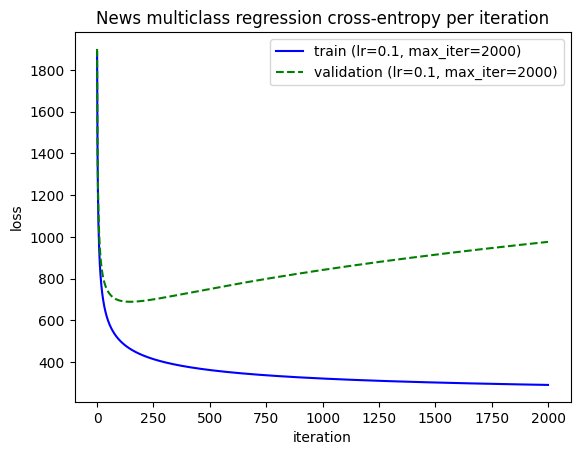

Classification accuracy of Multiclass Regression with learning rate 0.1 and max_iter 2000: 87.448%


In [56]:
def train_multi_reg(learning_rates_max_iters):
    news_multi_reg = Multinomial_logistic(news_X_train.shape[1], len(news_y_labels))
    X_train, X_valid, y_train, y_valid = model_selection.train_test_split(news_X_train, news_y_train_onehot, test_size=0.5, random_state=42)
    losses_train = []
    losses_valid = []

    for lr, max_iter in learning_rates_max_iters:
        news_multi_reg_losses_train, news_multi_reg_losses_valid = news_multi_reg.fit(X_train, y_train, X_valid, y_valid, learning_rate=lr, niter=max_iter)
        losses_train.append(news_multi_reg_losses_train)
        losses_valid.append(news_multi_reg_losses_valid)

    return losses_train, losses_valid

def news_plot_ce(train_loss, valid_loss, learning_rates_max_iters):
    for i in range(len(train_loss)):
        plt.figure()
        plt.plot(train_loss[i], label=f'train (lr={learning_rates_max_iters[i][0]}, max_iter={learning_rates_max_iters[i][1]})', color='b')
        plt.plot(valid_loss[i], label=f'validation (lr={learning_rates_max_iters[i][0]}, max_iter={learning_rates_max_iters[i][1]})', linestyle='--', color='g')
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.title(f'News multiclass regression cross-entropy per iteration')
        plt.legend()
        plt.show()

learning_rates_max_iters = [(0.1, 2000)]
news_multi_reg_losses_train, news_multi_reg_losses_valid = train_multi_reg(learning_rates_max_iters)
news_plot_ce(news_multi_reg_losses_train, news_multi_reg_losses_valid, learning_rates_max_iters)

# Calculate and print classification accuracy for each learning rate
for i in range(len(learning_rates_max_iters)):
    news_multi_reg_pred_probs = news_multi_reg.predict(news_X_test)
    news_multi_reg_pred = np.argmax(news_multi_reg_pred_probs, axis=1)
    accuracy = np.mean(news_multi_reg_pred == news_y_test) * 100
    print(f'Classification accuracy of Multiclass Regression with learning rate {learning_rates_max_iters[i][0]} and max_iter {learning_rates_max_iters[i][1]}: {accuracy:.3f}%')


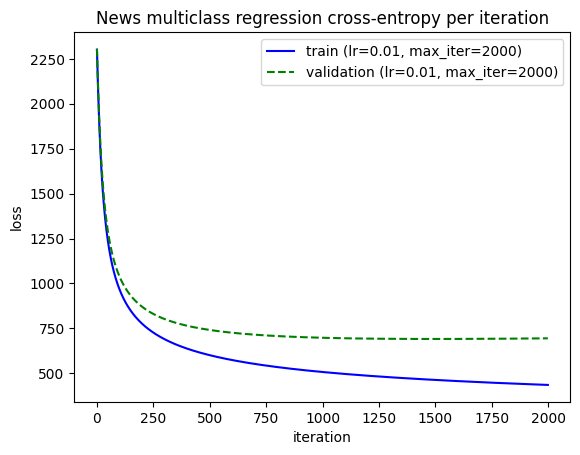

Classification accuracy of Multiclass Regression with learning rate 0.01 and max_iter 2000: 87.448%


In [57]:
learning_rates_max_iters = [(0.01, 2000)]
news_multi_reg_losses_train, news_multi_reg_losses_valid = train_multi_reg(learning_rates_max_iters)
news_plot_ce(news_multi_reg_losses_train, news_multi_reg_losses_valid, learning_rates_max_iters)

# Calculate and print classification accuracy for each learning rate
for i in range(len(learning_rates_max_iters)):
    news_multi_reg_pred_probs = news_multi_reg.predict(news_X_test)
    news_multi_reg_pred = np.argmax(news_multi_reg_pred_probs, axis=1)
    accuracy = np.mean(news_multi_reg_pred == news_y_test) * 100
    print(f'Classification accuracy of Multiclass Regression with learning rate {learning_rates_max_iters[i][0]} and max_iter {learning_rates_max_iters[i][1]}: {accuracy:.3f}%')


## 2. Explore more than 5 classes on News Data

### Trial 2.1 Using 8 not-too-similar classes

In [58]:
cats = ['comp.graphics', 'misc.forsale', 'sci.med', 'talk.politics.guns',
         'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey']

# exclude words that appear in less than 0.5% of the news, and in more than 30% of the news during the vectorization
NEWS_MIN_DF = 0.003
NEWS_MAX_DF = 0.3

In [59]:
vectorizer = TfidfVectorizer(min_df=NEWS_MIN_DF, max_df=NEWS_MAX_DF, stop_words='english')
vectors_train = vectorizer.fit_transform(news_train.data)
vectors_test = vectorizer.transform(news_test.data)
news_vocab = vectorizer.get_feature_names_out()
print(f'Class: {type(vectors_train)}', vectors_train.shape)
print(f'Class: {type(vectors_test)}', vectors_test.shape)
vectors_train

# print('How to get nonzero column indices in sparse matrix:\n', vectors_train[2].nonzero()[1])
# print(vectors_train[2, vectors_train[2].nonzero()[1][0]])
# print(news_vocab[vectors_train[2].nonzero()[1][0]])

Class: <class 'scipy.sparse._csr.csr_matrix'> (2906, 3816)
Class: <class 'scipy.sparse._csr.csr_matrix'> (1936, 3816)


<2906x3816 sparse matrix of type '<class 'numpy.float64'>'
	with 118456 stored elements in Compressed Sparse Row format>

In [60]:
c_vectorizer = CountVectorizer(min_df=NEWS_MIN_DF, max_df=NEWS_MAX_DF, stop_words='english')
c_vectors_train = c_vectorizer.fit_transform(news_train.data)
c_vectors_test = c_vectorizer.transform(news_test.data)
print(f'Class: {type(c_vectors_train)}', c_vectors_train.shape)
print(f'Class: {type(c_vectors_test)}', c_vectors_test.shape)
c_vectors_train

Class: <class 'scipy.sparse._csr.csr_matrix'> (2906, 3816)
Class: <class 'scipy.sparse._csr.csr_matrix'> (1936, 3816)


<2906x3816 sparse matrix of type '<class 'numpy.int64'>'
	with 118456 stored elements in Compressed Sparse Row format>

##### Filter out features

In [61]:
def news_count_occurrences(feat_vectors: csr_matrix):
  # count in how many rows did a feature appear
  feat_counts = {}
  for row in feat_vectors:
    for col in row.nonzero()[1]:
      if col in feat_counts:
        feat_counts[col] += 1
      else:
        feat_counts[col] = 1
  return feat_counts

In [62]:
news_feat_counts = news_count_occurrences(vectors_train)
print(len(news_feat_counts))
print_word_occurrences(news_feat_counts, news_vocab, feature=0)
#print_word_occurrences(news_feat_counts, news_vocab, word='gordon')

3816
The word "00" appears 111 times


In [63]:
# this shouldn't exclude any new values since we already filtered the features during vectorization: test if filter during vectorization is successful
NEWS_COUNT = len(news_train.target)
news_filtered_feats = set() # use set for O(1) lookups
news_excluded_feats = set()
for feat, count in news_feat_counts.items():
  if count < (NEWS_MIN_DF * NEWS_COUNT) or count > (NEWS_MAX_DF * NEWS_COUNT):
    news_excluded_feats.add(feat)
  else:
    news_filtered_feats.add(feat)

print(f'Number of excluded features: {len(news_excluded_feats)}')
print(f'Number of filtered features: {len(news_filtered_feats)}')
print(f'First 10 excluded words: {[news_vocab[feat] for feat in list(news_excluded_feats)[:10]]}')
print(f'Filtered words: {[news_vocab[feat] for feat in news_filtered_feats]}')

Number of excluded features: 0
Number of filtered features: 3816
First 10 excluded words: []
Filtered words: ['00', '000', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '101', '1024x768', '104', '105', '106', '108', '109', '11', '110', '118', '12', '120', '1200', '125', '127', '128', '129', '13', '130', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '143', '144', '146', '147', '149', '15', '150', '152', '158', '159', '16', '160', '161', '162', '167', '17', '172', '175', '179', '18', '180', '19', '192', '1960', '1962', '1964', '1968', '1969', '1976', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1b', '1st', '20', '200', '2000', '201', '202', '206', '21', '210', '215', '216', '22', '220', '225', '23', '230', '238', '24', '240', '2400', '246', '249', '25', '250', '255', '256', '25mhz', '26', '263', '267', '268', '27', '270', '275', '277', '278', '28', '280', '286', 

In [64]:
def filter_feature_vector(feat_vectors: csr_matrix, filtered_feats: set[int]):
  filter_columns = np.zeros(feat_vectors.shape[1])
  filter_columns[list(filtered_feats)] = 1 # set to 1 if feature is included
  filter_matrix = diags(filter_columns, dtype = feat_vectors.dtype) # create a diagonal matrix with the filter_columns as the diagonal
  # print(filter_matrix.A)
  res = feat_vectors @ filter_matrix # matrix multiplication
  res.eliminate_zeros() # remove zero entries
  return res

In [65]:
vectors_train_filtered = filter_feature_vector(vectors_train, news_filtered_feats)
c_vectors_train_filtered = filter_feature_vector(c_vectors_train, news_filtered_feats)
print(f'Class: {type(vectors_train_filtered)}', vectors_train_filtered.shape)
vectors_train_filtered

Class: <class 'scipy.sparse._csr.csr_matrix'> (2906, 3816)


<2906x3816 sparse matrix of type '<class 'numpy.float64'>'
	with 118456 stored elements in Compressed Sparse Row format>

##### Choose top features using mutual information

In [66]:
# unused function since sklearn.feature_selection.mutual_info_classif does the same thing but faster
def news_mi(feat_vectors: csr_matrix, y: np.ndarray, filtered_feats: set):
  mi_scores = {} # key: feature, value: mi
  for feat in filtered_feats:
    # X: value of feat in each row, y: ground truth of each row
    X = np.zeros(feat_vectors.shape[0])
    for id in range(feat_vectors.shape[0]):
      if feat in feat_vectors[id].nonzero()[1]: # if feature is present in the row of sparse matrix
        X[id] = feat_vectors[id, feat]
    mi_scores[feat] = mutual_info_score(y, X)
  return mi_scores

In [67]:
news_cat_mi_scores = []
news_cat_top_100 = []
for id, cat in enumerate(news_train.target_names):
  print(f'Category: {cat}')
  cat_target = (news_train.target == id).astype(int) # 1 if the category is the current category, 0 otherwise
  cat_mi_scores = mutual_info_classif(c_vectors_train_filtered, cat_target, random_state=42)
  cat_mi_scores = {feat: mi for feat, mi in enumerate(cat_mi_scores)}
  cat_top_100 = sorted(cat_mi_scores, key=cat_mi_scores.get, reverse=True)[:100]
  news_cat_mi_scores.append(cat_mi_scores)
  news_cat_top_100.append(cat_top_100)
  print(f'Top 100 words with the highest MI scores: {[news_vocab[feat] for feat in cat_top_100]}')
  print(f'MI scores: {[round(cat_mi_scores[feat], 5) for feat in cat_top_100]}')
  print()

Category: comp.graphics
Top 100 words with the highest MI scores: ['graphics', 'files', 'image', 'program', 'file', '3d', 'ftp', 'code', 'images', 'format', 'thanks', 'sale', 'gif', 'algorithm', 'hi', 'animation', 'people', 'programs', 'gun', 'advance', 'polygon', 'screen', 'convert', 'directory', 'software', 'formats', 'computer', 'tiff', 'hardware', 'year', 'programming', 'colors', 'algorithms', 'vga', '256', 'windows', 'pov', 'version', 'comp', 'color', 'help', 'mode', 'mac', 'jpeg', 'using', 'site', 'pixel', 'object', 'unix', 'video', 'package', 'sphere', 'guns', 'pub', 'baseball', 'surface', 'condition', 'points', 'routines', 'interface', 'available', 'write', 'appreciated', 'sgi', 'virtual', 'vesa', 'dos', 'viewer', 'pc', 'display', 'pcx', 'library', 'new', 'ray', 'siggraph', 'bmp', 'visualization', 'sites', 'weapons', 'map', 'drawing', 'bit', 'years', 'shareware', 'need', 'anonymous', 'team', 'postscript', 'edu', 'banks', 'pixels', 'cview', 'polygons', 'bitmap', 'systems', 'game

In [68]:
news_mi_feats = set()
for cat_top_100 in news_cat_top_100:
  for feat in cat_top_100[:80]:
    news_mi_feats.add(feat)

print([news_vocab[feat] for feat in news_mi_feats])
print(f'Total selected features: {len(news_mi_feats)}')

['00', '10', '100', '15', '150', 'mac', 'mail', 'majors', 'manual', 'manuals', 'map', '20', '25', '250', '256', 'med', 'medical', 'medicine', '30', '300', 'meg', 'mets', '3d', 'military', 'militia', '50', 'mint', 'mode', 'modem', 'monitor', 'motherboard', 'msg', 'murder', 'aaa', 'abiding', 'n3jxp', 'national', 'new', 'nl', 'advance', 'normal', 'agents', 'nra', 'object', 'algorithm', 'algorithms', 'obo', 'allergic', 'alomar', 'offense', 'offer', 'amendment', 'offers', 'officers', 'animation', 'original', 'orioles', 'appreciated', 'package', 'packaging', 'pain', 'armed', 'arms', 'asking', 'assault', 'patient', 'patients', 'atf', 'pc', 'pcx', 'people', 'available', 'average', 'phillies', 'phone', 'physician', 'physicians', 'ball', 'ban', 'banks', 'pitch', 'pitched', 'baseball', 'pitcher', 'pitchers', 'pitching', 'pitt', 'pixel', 'batf', 'batting', 'bd', 'bear', 'play', 'believe', 'players', 'player', 'plus', 'point', 'better', 'points', 'police', 'politics', 'polygon', 'population', 'bloo

In [69]:
vectors_train_filtered = filter_feature_vector(vectors_train, news_mi_feats)
c_vectors_train_filtered = filter_feature_vector(c_vectors_train, news_mi_feats)
vectors_train_filtered

<2906x3816 sparse matrix of type '<class 'numpy.float64'>'
	with 24689 stored elements in Compressed Sparse Row format>

In [70]:
# we need to convert targets to one-hot encoding for fitting
def to_onehot(y, nClasses):
    return np.eye(nClasses)[y]

news_y_labels = news_train.target_names

news_X_train = vectors_train_filtered
news_y_train = news_train.target
news_y_train_onehot = to_onehot(news_y_train, len(news_y_labels))

news_X_test = vectors_test
news_y_test = news_test.target

##### Monitor cross-entropy

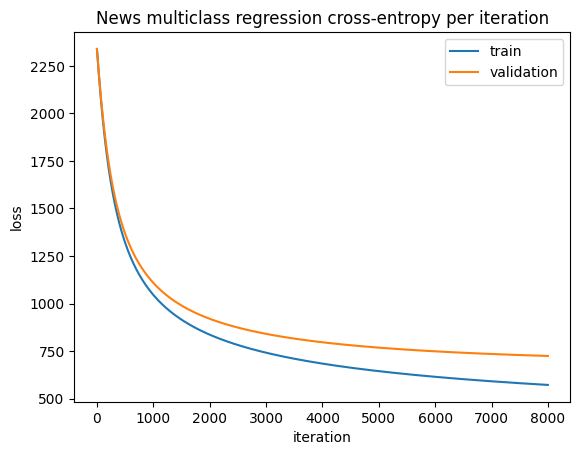

In [71]:
news_multi_reg = Multinomial_logistic(news_X_train.shape[1], len(news_y_labels))

def train_multi_reg():
  X_train, X_valid, y_train, y_valid = model_selection.train_test_split(news_X_train, news_y_train_onehot, test_size=0.5, random_state=42)
  news_multi_reg_losses_train, news_multi_reg_losses_valid = news_multi_reg.fit(X_train, y_train, X_valid, y_valid, learning_rate=0.001, niter=8000)
  return news_multi_reg_losses_train, news_multi_reg_losses_valid

def news_plot_ce(train_loss, valid_loss):
  plt.plot(train_loss, label='train')
  plt.plot(valid_loss, label='validation')
  plt.xlabel('iteration')
  plt.ylabel('loss')
  plt.title('News multiclass regression cross-entropy per iteration')
  plt.legend()

news_multi_reg_losses_train, news_multi_reg_losses_valid = train_multi_reg()
news_plot_ce(news_multi_reg_losses_train, news_multi_reg_losses_valid)

In the plot above, we observe that both the training and validation cross-entropy curves continue to decrease, showing no sign of overfitting.

##### Evaluating classification accuracy

In [72]:

news_multi_reg_pred_probs = news_multi_reg.predict(news_X_test)

k = 2
topk_classes = np.argsort(-news_multi_reg_pred_probs, axis=1)[:, :k]

# Check if the true label is within the top 3 predicted classes for each record
correct_predictions = np.array([true_label in top_labels for true_label, top_labels in zip(news_y_test, topk_classes)])

# Calculate the classification accuracy based on top 3 predictions
accuracy_topk = np.mean(correct_predictions)
print(f'Classification accuracy based on Top k predicted classes: {accuracy_topk * 100:.3f}%')
#news_multi_reg_pred = np.argmax(news_multi_reg_pred_probs, axis=1)
#print(f'Classification accuracy of Multiclass Regression: {np.mean(news_multi_reg_pred == news_y_test) * 100:.3f}%')

Classification accuracy based on Top k predicted classes: 93.957%


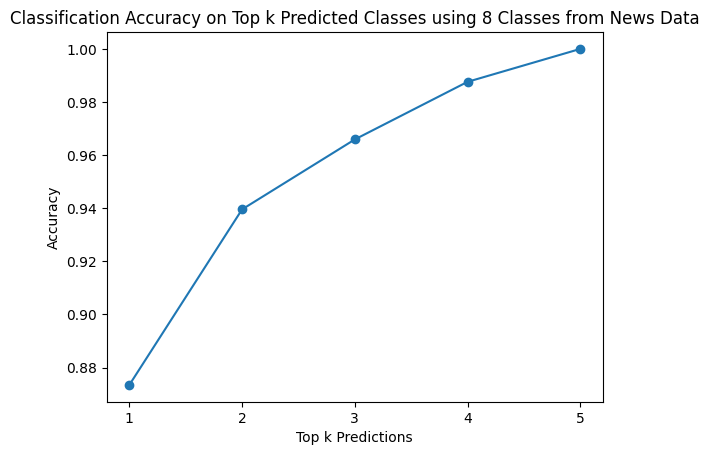

In [73]:
def plot_accuracy_on_k(news_y_test):
    k_values = [1, 2, 3, 4, 5]  # Different k values to consider
    accuracies = []

    for k in k_values:
        topk_classes = np.argsort(-news_multi_reg_pred_probs, axis=1)[:, :k]

        correct_predictions = np.array([true_label in top_labels for true_label, top_labels in zip(news_y_test, topk_classes)])
        accuracy_topk = np.mean(correct_predictions)
        accuracies.append(accuracy_topk)

    # Plot the accuracy based on different k values
    plt.figure()
    plt.plot(k_values, accuracies, marker='o')
    plt.xlabel('Top k Predictions')
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy on Top k Predicted Classes using 8 Classes from News Data')
    plt.xticks(np.arange(min(k_values), max(k_values)+1, 1))
    plt.show()

# Call the function with your data
plot_accuracy_on_k(news_y_test)

### Trial 2.2: 8 very-similar classes

In [74]:
cats = [
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']
news_train = fetch_20newsgroups(subset='train',categories=cats, remove=('headers', 'footers', 'quotes'))
news_test = fetch_20newsgroups(subset='test', categories=cats)
# exclude words that appear in less than 0.5% of the news, and in more than 30% of the news during the vectorization
NEWS_MIN_DF = 0.006
NEWS_MAX_DF = 0.3

#### STEPS

In [75]:
vectorizer = TfidfVectorizer(min_df=NEWS_MIN_DF, max_df=NEWS_MAX_DF, stop_words='english')
vectors_train = vectorizer.fit_transform(news_train.data)
vectors_test = vectorizer.transform(news_test.data)
news_vocab = vectorizer.get_feature_names_out()
print(f'Class: {type(vectors_train)}', vectors_train.shape)
print(f'Class: {type(vectors_test)}', vectors_test.shape)
vectors_train
# print('How to get nonzero column indices in sparse matrix:\n', vectors_train[2].nonzero()[1])
# print(vectors_train[2, vectors_train[2].nonzero()[1][0]])
# print(news_vocab[vectors_train[2].nonzero()[1][0]])

Class: <class 'scipy.sparse._csr.csr_matrix'> (4304, 2225)
Class: <class 'scipy.sparse._csr.csr_matrix'> (2867, 2225)


<4304x2225 sparse matrix of type '<class 'numpy.float64'>'
	with 168114 stored elements in Compressed Sparse Row format>

In [76]:
c_vectorizer = CountVectorizer(min_df=NEWS_MIN_DF, max_df=NEWS_MAX_DF, stop_words='english')
c_vectors_train = c_vectorizer.fit_transform(news_train.data)
c_vectors_test = c_vectorizer.transform(news_test.data)
print(f'Class: {type(c_vectors_train)}', c_vectors_train.shape)
print(f'Class: {type(c_vectors_test)}', c_vectors_test.shape)
c_vectors_train

Class: <class 'scipy.sparse._csr.csr_matrix'> (4304, 2225)
Class: <class 'scipy.sparse._csr.csr_matrix'> (2867, 2225)


<4304x2225 sparse matrix of type '<class 'numpy.int64'>'
	with 168114 stored elements in Compressed Sparse Row format>

##### Filter out features

In [77]:
def news_count_occurrences(feat_vectors: csr_matrix):
  # count in how many rows did a feature appear
  feat_counts = {}
  for row in feat_vectors:
    for col in row.nonzero()[1]:
      if col in feat_counts:
        feat_counts[col] += 1
      else:
        feat_counts[col] = 1
  return feat_counts

In [78]:
news_feat_counts = news_count_occurrences(vectors_train)
print(len(news_feat_counts))
print_word_occurrences(news_feat_counts, news_vocab, feature=0)
#print_word_occurrences(news_feat_counts, news_vocab, word='gordon')

2225
The word "00" appears 64 times


In [79]:
# this shouldn't exclude any new values since we already filtered the features during vectorization: test if filter during vectorization is successful
NEWS_COUNT = len(news_train.target)
news_filtered_feats = set() # use set for O(1) lookups
news_excluded_feats = set()
for feat, count in news_feat_counts.items():
  if count < (NEWS_MIN_DF * NEWS_COUNT) or count > (NEWS_MAX_DF * NEWS_COUNT):
    news_excluded_feats.add(feat)
  else:
    news_filtered_feats.add(feat)

print(f'Number of excluded features: {len(news_excluded_feats)}')
print(f'Number of filtered features: {len(news_filtered_feats)}')
print(f'First 10 excluded words: {[news_vocab[feat] for feat in list(news_excluded_feats)[:10]]}')
print(f'Filtered words: {[news_vocab[feat] for feat in news_filtered_feats]}')

Number of excluded features: 0
Number of filtered features: 2225
First 10 excluded words: []
Filtered words: ['00', '000', '01', '02', '04', '10', '100', '1000', '1024x768', '11', '12', '120', '13', '14', '140', '15', '150', '16', '17', '18', '19', '1914', '1920', '1982', '1988', '1989', '1990', '1991', '1992', '1993', '20', '200', '21', '22', '23', '24', '25', '250', '256', '26', '27', '28', '286', '29', '2nd', '30', '300', '31', '32', '33', '34', '35', '36', '37', '38', '386', '39', '40', '400', '41', '42', '43', '44', '45', '46', '47', '48', '486', '49', '50', '500', '51', '59', '60', '600', '64', '66', '70', '700', '72', '75', '80', '800', '86', '90', '92', '93', '99', 'ability', 'able', 'absolute', 'absolutely', 'abuse', 'ac', 'accelerator', 'accept', 'acceptable', 'accepted', 'access', 'according', 'account', 'accounts', 'accurate', 'act', 'acting', 'action', 'actions', 'active', 'activities', 'activity', 'acts', 'actual', 'actually', 'ad', 'adam', 'adapter', 'add', 'added', 'add

In [80]:
def filter_feature_vector(feat_vectors: csr_matrix, filtered_feats: set[int]):
  filter_columns = np.zeros(feat_vectors.shape[1])
  filter_columns[list(filtered_feats)] = 1 # set to 1 if feature is included
  filter_matrix = diags(filter_columns, dtype = feat_vectors.dtype) # create a diagonal matrix with the filter_columns as the diagonal
  # print(filter_matrix.A)
  res = feat_vectors @ filter_matrix # matrix multiplication
  res.eliminate_zeros() # remove zero entries
  return res

In [81]:
vectors_train_filtered = filter_feature_vector(vectors_train, news_filtered_feats)
c_vectors_train_filtered = filter_feature_vector(c_vectors_train, news_filtered_feats)
print(f'Class: {type(vectors_train_filtered)}', vectors_train_filtered.shape)
vectors_train_filtered

Class: <class 'scipy.sparse._csr.csr_matrix'> (4304, 2225)


<4304x2225 sparse matrix of type '<class 'numpy.float64'>'
	with 168114 stored elements in Compressed Sparse Row format>

In [82]:
# unused function since sklearn.feature_selection.mutual_info_classif does the same thing but faster
def news_mi(feat_vectors: csr_matrix, y: np.ndarray, filtered_feats: set):
  mi_scores = {} # key: feature, value: mi
  for feat in filtered_feats:
    # X: value of feat in each row, y: ground truth of each row
    X = np.zeros(feat_vectors.shape[0])
    for id in range(feat_vectors.shape[0]):
      if feat in feat_vectors[id].nonzero()[1]: # if feature is present in the row of sparse matrix
        X[id] = feat_vectors[id, feat]
    mi_scores[feat] = mutual_info_score(y, X)
  return mi_scores

In [83]:
news_cat_mi_scores = []
news_cat_top_100 = []
for id, cat in enumerate(news_train.target_names):
  print(f'Category: {cat}')
  cat_target = (news_train.target == id).astype(int) # 1 if the category is the current category, 0 otherwise
  cat_mi_scores = mutual_info_classif(c_vectors_train_filtered, cat_target, random_state=42)
  cat_mi_scores = {feat: mi for feat, mi in enumerate(cat_mi_scores)}
  cat_top_100 = sorted(cat_mi_scores, key=cat_mi_scores.get, reverse=True)[:100]
  news_cat_mi_scores.append(cat_mi_scores)
  news_cat_top_100.append(cat_top_100)
  print(f'Top 100 words with the highest MI scores: {[news_vocab[feat] for feat in cat_top_100]}')
  print(f'MI scores: {[round(cat_mi_scores[feat], 5) for feat in cat_top_100]}')
  print()

Category: comp.os.ms-windows.misc
Top 100 words with the highest MI scores: ['windows', 'dos', 'file', 'cica', 'files', 'ms', 'people', 'ftp', 'driver', 'microsoft', 'drivers', 'win', 'government', 'ini', 'zip', 'exe', 'nt', 'directory', 'version', 'program', 'state', 'pc', 'indiana', 'fonts', '34', 'fact', 'law', 'country', 'card', 'printer', 'hi', '86', 'did', 'years', 'using', 'israel', 'mi', 'tm', 'killed', 'gun', 'rights', 'children', 'power', 'say', 'making', 'said', 'max', 'jews', 'diamond', 'mr', 'war', 'weapons', 'ap', 'evidence', 'agree', 'guns', 'apple', 'norton', 'apps', 'israeli', 'course', 'states', 'font', 'military', 'desktop', 'crime', 'right', '45', 'time', '14', 'population', '386', 'ah', 'human', 'day', 'utilities', 'case', 'given', 'man', 'ma', 'men', 'run', 'american', 'political', 'police', 'life', '75', 'mail', 'jewish', 'long', 'god', 'care', 'manager', 'national', 'women', 'land', 'policy', 'mode', 'death', 'united']
MI scores: [0.08529, 0.02203, 0.02144, 0.01

In [84]:
news_mi_feats = set()
for cat_top_100 in news_cat_top_100:
  for feat in cat_top_100[:80]:
    news_mi_feats.add(feat)

print([news_vocab[feat] for feat in news_mi_feats])
print(f'Total selected features: {len(news_mi_feats)}')

['transfer', 'troops', 'true', '14', 'truth', '16', 'turkish', 'turks', 'turkey', '1914', 'united', 'unix', 'upgrade', 'use', '33', '34', 'user', 'using', 'usr', '386', 'utilities', '45', '486', 'version', 'vesa', 'vga', 'video', 'village', 'villages', 'violent', '86', 'visual', 'vlb', 'vram', 'waco', 'accelerator', 'war', 'washington', 'weapon', 'weapons', 'white', 'administration', 'advance', 'widget', 'widgets', 'win', 'window', 'windows', 'agents', 'witness', 'agree', 'women', 'ah', 'word', 'words', 'work', 'working', 'world', 'amendment', 'wouldn', 'american', 'americans', 'x11', 'x11r4', 'x11r5', 'xlib', 'xt', 'xterm', 'xview', 'anti', 'ap', 'year', 'years', 'zip', 'apple', 'application', 'apps', 'april', 'arab', 'arabs', 'arf', 'argic', 'armed', 'armenia', 'armenian', 'armenians', 'arms', 'army', 'assault', 'atf', 'attack', 'attacks', 'auto', 'automatic', 'azerbaijan', 'azeri', 'batf', 'bd', 'bear', 'belief', 'beliefs', 'believe', 'bible', 'bios', 'bit', 'blood', 'board', 'board

In [85]:
vectors_train_filtered = filter_feature_vector(vectors_train, news_mi_feats)
c_vectors_train_filtered = filter_feature_vector(c_vectors_train, news_mi_feats)
vectors_train_filtered

<4304x2225 sparse matrix of type '<class 'numpy.float64'>'
	with 48806 stored elements in Compressed Sparse Row format>

In [86]:
# we need to convert targets to one-hot encoding for fitting
def to_onehot(y, nClasses):
    return np.eye(nClasses)[y]

news_y_labels = news_train.target_names

news_X_train = vectors_train_filtered
news_y_train = news_train.target
news_y_train_onehot = to_onehot(news_y_train, len(news_y_labels))

news_X_test = vectors_test
news_y_test = news_test.target

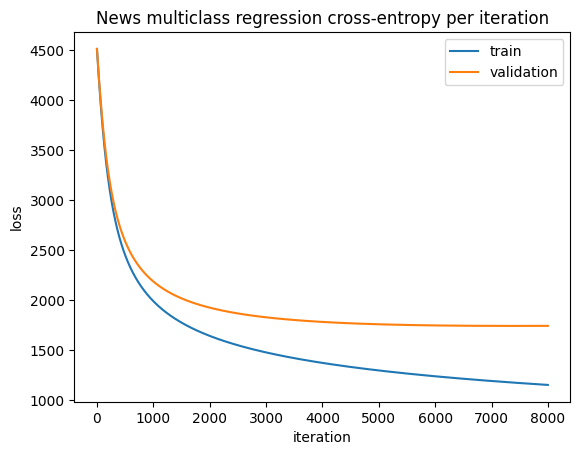

In [87]:
news_multi_reg = Multinomial_logistic(news_X_train.shape[1], len(news_y_labels))

def train_multi_reg():
  X_train, X_valid, y_train, y_valid = model_selection.train_test_split(news_X_train, news_y_train_onehot, test_size=0.5, random_state=42)
  news_multi_reg_losses_train, news_multi_reg_losses_valid = news_multi_reg.fit(X_train, y_train, X_valid, y_valid, learning_rate=0.001, niter=8000)
  return news_multi_reg_losses_train, news_multi_reg_losses_valid

def news_plot_ce(train_loss, valid_loss):
  plt.plot(train_loss, label='train')
  plt.plot(valid_loss, label='validation')
  plt.xlabel('iteration')
  plt.ylabel('loss')
  plt.title('News multiclass regression cross-entropy per iteration')
  plt.legend()

news_multi_reg_losses_train, news_multi_reg_losses_valid = train_multi_reg()
news_plot_ce(news_multi_reg_losses_train, news_multi_reg_losses_valid)

In the plot above, we observe that both the training and validation cross-entropy curves continue to decrease, showing no sign of overfitting.

##### Evaluating classification accuracy

In [88]:

news_multi_reg_pred_probs = news_multi_reg.predict(news_X_test)

k = 2
topk_classes = np.argsort(-news_multi_reg_pred_probs, axis=1)[:, :k]

# Check if the true label is within the top 3 predicted classes for each record
correct_predictions = np.array([true_label in top_labels for true_label, top_labels in zip(news_y_test, topk_classes)])

# Calculate the classification accuracy based on top 3 predictions
accuracy_topk = np.mean(correct_predictions)
print(f'Classification accuracy based on Top k predicted classes: {accuracy_topk * 100:.3f}%')
#news_multi_reg_pred = np.argmax(news_multi_reg_pred_probs, axis=1)
#print(f'Classification accuracy of Multiclass Regression: {np.mean(news_multi_reg_pred == news_y_test) * 100:.3f}%')

Classification accuracy based on Top k predicted classes: 86.641%


#### Result

In [89]:
def plot_accuracy_on_k(news_y_test):
    k_values = [1, 2, 3, 4, 5]  # Different k values to consider
    accuracies = []

    for k in k_values:
        topk_classes = np.argsort(-news_multi_reg_pred_probs, axis=1)[:, :k]

        correct_predictions = np.array([true_label in top_labels for true_label, top_labels in zip(news_y_test, topk_classes)])
        accuracy_topk = np.mean(correct_predictions)
        accuracies.append(accuracy_topk)

    # Plot the accuracy based on different k values
    plt.figure()
    plt.plot(k_values, accuracies, marker='o')
    plt.xlabel('Top k Predictions')
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy on Top k Predicted Classes using 8 Similar Classes from News Data')
    plt.xticks(np.arange(min(k_values), max(k_values)+1, 1))
    plt.show()

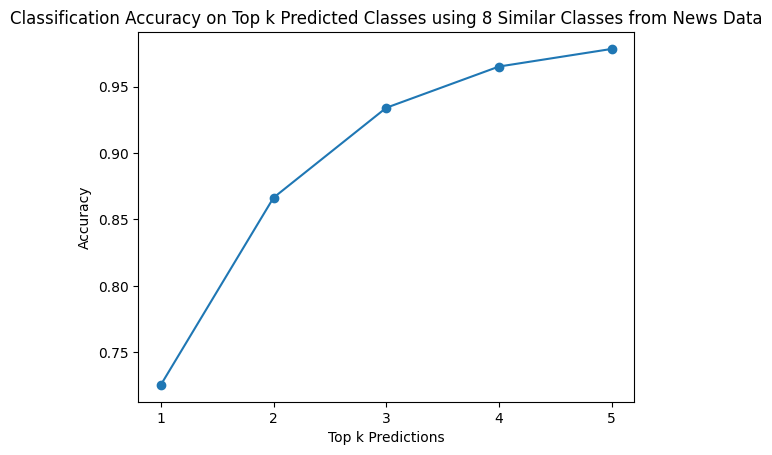

In [90]:
# Call the function with your data
plot_accuracy_on_k(news_y_test)

### Trial 2.3: 12 Classes

In [91]:
cats = ['comp.graphics', 'misc.forsale', 'sci.med', 'talk.politics.guns',
         'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',]

# exclude words that appear in less than 0.5% of the news, and in more than 30% of the news during the vectorization
NEWS_MIN_DF = 0.0023
NEWS_MAX_DF = 0.4

In [92]:
vectorizer = TfidfVectorizer(min_df=NEWS_MIN_DF, max_df=NEWS_MAX_DF, stop_words='english')
vectors_train = vectorizer.fit_transform(news_train.data)
vectors_test = vectorizer.transform(news_test.data)
news_vocab = vectorizer.get_feature_names_out()
print(f'Class: {type(vectors_train)}', vectors_train.shape)
print(f'Class: {type(vectors_test)}', vectors_test.shape)
vectors_train

# print('How to get nonzero column indices in sparse matrix:\n', vectors_train[2].nonzero()[1])
# print(vectors_train[2, vectors_train[2].nonzero()[1][0]])
# print(news_vocab[vectors_train[2].nonzero()[1][0]])

Class: <class 'scipy.sparse._csr.csr_matrix'> (4304, 5459)
Class: <class 'scipy.sparse._csr.csr_matrix'> (2867, 5459)


<4304x5459 sparse matrix of type '<class 'numpy.float64'>'
	with 217152 stored elements in Compressed Sparse Row format>

In [93]:
c_vectorizer = CountVectorizer(min_df=NEWS_MIN_DF, max_df=NEWS_MAX_DF, stop_words='english')
c_vectors_train = c_vectorizer.fit_transform(news_train.data)
c_vectors_test = c_vectorizer.transform(news_test.data)
print(f'Class: {type(c_vectors_train)}', c_vectors_train.shape)
print(f'Class: {type(c_vectors_test)}', c_vectors_test.shape)
c_vectors_train

Class: <class 'scipy.sparse._csr.csr_matrix'> (4304, 5459)
Class: <class 'scipy.sparse._csr.csr_matrix'> (2867, 5459)


<4304x5459 sparse matrix of type '<class 'numpy.int64'>'
	with 217152 stored elements in Compressed Sparse Row format>

##### Filter out features

In [94]:
def news_count_occurrences(feat_vectors: csr_matrix):
  # count in how many rows did a feature appear
  feat_counts = {}
  for row in feat_vectors:
    for col in row.nonzero()[1]:
      if col in feat_counts:
        feat_counts[col] += 1
      else:
        feat_counts[col] = 1
  return feat_counts

In [95]:
news_feat_counts = news_count_occurrences(vectors_train)
print(len(news_feat_counts))
print_word_occurrences(news_feat_counts, news_vocab, feature=0)
#print_word_occurrences(news_feat_counts, news_vocab, word='gordon')

5459
The word "00" appears 64 times


In [96]:
# this shouldn't exclude any new values since we already filtered the features during vectorization: test if filter during vectorization is successful
NEWS_COUNT = len(news_train.target)
news_filtered_feats = set() # use set for O(1) lookups
news_excluded_feats = set()
for feat, count in news_feat_counts.items():
  if count < (NEWS_MIN_DF * NEWS_COUNT) or count > (NEWS_MAX_DF * NEWS_COUNT):
    news_excluded_feats.add(feat)
  else:
    news_filtered_feats.add(feat)

print(f'Number of excluded features: {len(news_excluded_feats)}')
print(f'Number of filtered features: {len(news_filtered_feats)}')
print(f'First 10 excluded words: {[news_vocab[feat] for feat in list(news_excluded_feats)[:10]]}')
print(f'Filtered words: {[news_vocab[feat] for feat in news_filtered_feats]}')

Number of excluded features: 0
Number of filtered features: 5459
First 10 excluded words: []
Filtered words: ['00', '000', '01', '02', '03', '030', '04', '040', '05', '06', '07', '08', '09', '0b', '0d', '0h', '0i', '0l', '0m', '0q', '0qax', '0t', '10', '100', '1000', '102', '1024', '1024x768', '103', '104', '105', '109', '10mb', '11', '12', '120', '1200', '125', '127', '128', '1280x1024', '129', '12mb', '13', '130', '132', '133', '14', '140', '144', '145', '146', '147', '148', '15', '150', '16', '160', '16550', '16mb', '17', '170', '175', '18', '180', '19', '1900', '1914', '1915', '1918', '1919', '1920', '1923', '1926', '1934', '1940', '1948', '1960', '1964', '1967', '1968', '1974', '1975', '1977', '1978', '1979', '198', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '199', '1990', '1991', '1992', '1993', '1a', '1d', '1d9', '1d9l', '1eq', '1f', '1fp', '1fpl', '1k', '1m', '1mb', '1p', '1s', '1st', '1t', '1v', '20', '200', '2000', '202', '20mb', '20th', '

In [97]:
def filter_feature_vector(feat_vectors: csr_matrix, filtered_feats: set[int]):
  filter_columns = np.zeros(feat_vectors.shape[1])
  filter_columns[list(filtered_feats)] = 1 # set to 1 if feature is included
  filter_matrix = diags(filter_columns, dtype = feat_vectors.dtype) # create a diagonal matrix with the filter_columns as the diagonal
  # print(filter_matrix.A)
  res = feat_vectors @ filter_matrix # matrix multiplication
  res.eliminate_zeros() # remove zero entries
  return res

In [98]:
vectors_train_filtered = filter_feature_vector(vectors_train, news_filtered_feats)
c_vectors_train_filtered = filter_feature_vector(c_vectors_train, news_filtered_feats)
print(f'Class: {type(vectors_train_filtered)}', vectors_train_filtered.shape)
vectors_train_filtered

Class: <class 'scipy.sparse._csr.csr_matrix'> (4304, 5459)


<4304x5459 sparse matrix of type '<class 'numpy.float64'>'
	with 217152 stored elements in Compressed Sparse Row format>

##### Choose top features using mutual information

In [99]:
# unused function since sklearn.feature_selection.mutual_info_classif does the same thing but faster
def news_mi(feat_vectors: csr_matrix, y: np.ndarray, filtered_feats: set):
  mi_scores = {} # key: feature, value: mi
  for feat in filtered_feats:
    # X: value of feat in each row, y: ground truth of each row
    X = np.zeros(feat_vectors.shape[0])
    for id in range(feat_vectors.shape[0]):
      if feat in feat_vectors[id].nonzero()[1]: # if feature is present in the row of sparse matrix
        X[id] = feat_vectors[id, feat]
    mi_scores[feat] = mutual_info_score(y, X)
  return mi_scores

In [100]:
news_cat_mi_scores = []
news_cat_top_100 = []
for id, cat in enumerate(news_train.target_names):
  print(f'Category: {cat}')
  cat_target = (news_train.target == id).astype(int) # 1 if the category is the current category, 0 otherwise
  cat_mi_scores = mutual_info_classif(c_vectors_train_filtered, cat_target, random_state=42)
  cat_mi_scores = {feat: mi for feat, mi in enumerate(cat_mi_scores)}
  cat_top_100 = sorted(cat_mi_scores, key=cat_mi_scores.get, reverse=True)[:100]
  news_cat_mi_scores.append(cat_mi_scores)
  news_cat_top_100.append(cat_top_100)
  print(f'Top 100 words with the highest MI scores: {[news_vocab[feat] for feat in cat_top_100]}')
  print(f'MI scores: {[round(cat_mi_scores[feat], 5) for feat in cat_top_100]}')
  print()

Category: comp.os.ms-windows.misc
Top 100 words with the highest MI scores: ['windows', 'dos', 'file', 'cica', 'files', 'ms', 'people', 'ftp', 'driver', 'microsoft', 'drivers', 'win3', 'win', 'government', 'ini', 'bj', 'zip', 'exe', 'nt', 'directory', 'mq', 'version', 'program', '1t', 'd9', 'wm', 'lj', 'mw', 'ei', 'state', 'pc', 'wt', '0t', 'lg', 'indiana', 'fonts', 'pl', '34', 'mn', '9v', '3t', 'm3', '6e', 'bmp', '3l', 'ax', 'm9', 'm_', 'm7', 'gk', '34u', '6ei', 'ml', 'tq', 'fact', 'law', 'm1', 'truetype', 'q6', '4t', '9d', 'km', 'country', 'mc', 'qq', '1d9', 'b8f', 'bhj', 'g9v', '9f', 'tg', '8n', 'm4', 'gq', 'card', 'mu', 'printer', 'hi', '86', 'did', 'years', 'using', 'israel', 'kn', '0q', '5u', 'mi', 'yd', '1f', '9l', '3q', '9p', '_o', 'a86', 'g9', 'uy', 'z5', 'tm', 'f0', 'shareware']
MI scores: [0.08529, 0.02203, 0.02144, 0.01911, 0.01809, 0.01619, 0.0153, 0.01337, 0.01206, 0.01129, 0.01114, 0.0107, 0.01035, 0.00978, 0.0097, 0.00922, 0.0091, 0.00892, 0.00873, 0.00848, 0.00839, 0.0

In [101]:
news_mi_feats = set()
for cat_top_100 in news_cat_top_100:
  for feat in cat_top_100[:80]:
    news_mi_feats.add(feat)

print([news_vocab[feat] for feat in news_mi_feats])
print(f'Total selected features: {len(news_mi_feats)}')

['federal', '040', 'religion', 'religions', 'religious', '0t', 'reno', 'file', 'files', 'firearm', 'firearms', '16', 'republic', 'republicans', 'request', '1914', 'floppy', 'resource', 'folks', 'follow', 'followers', 'following', 'fonts', 'force', 'forces', '1d9', 'reject', '1t', 'fpu', 'rifle', 'rifles', 'righteous', 'rights', 'ftp', 'function', 'rkba', 'functions', 'funds', 'g9v', 'rom', '33', '34', '34u', 'gas', 'gateway', 'gay', 'gays', 'gaza', 'gcc', '3l', 'running', '3t', 'russian', 'genocide', 'safety', '486', 'said', 'salvation', 'gk', '4t', 'say', '512k', 'god', 'gospel', 'scholars', 'government', '610', 'gq', '650', 'scripture', 'scriptures', 'scsi', 'se', '68040', 'seagate', '68030', '6e', '6ei', 'greek', 'secretary', 'self', 'semi', 'gun', 'guns', '86', 'senate', '8n', 'sense', '950', 'handgun', 'handguns', 'handheld', 'serdar', '9d', '9f', 'server', '9mm', '9v', 'set', 'settings', 'hard', 'hardware', 'abiding', 'sex', 'sexual', 'hci', 'hd', 'health', 'accidents', 'heaven',

In [102]:
vectors_train_filtered = filter_feature_vector(vectors_train, news_mi_feats)
c_vectors_train_filtered = filter_feature_vector(c_vectors_train, news_mi_feats)
vectors_train_filtered

<4304x5459 sparse matrix of type '<class 'numpy.float64'>'
	with 41970 stored elements in Compressed Sparse Row format>

In [103]:
# we need to convert targets to one-hot encoding for fitting
def to_onehot(y, nClasses):
    return np.eye(nClasses)[y]

news_y_labels = news_train.target_names

news_X_train = vectors_train_filtered
news_y_train = news_train.target
news_y_train_onehot = to_onehot(news_y_train, len(news_y_labels))

news_X_test = vectors_test
news_y_test = news_test.target

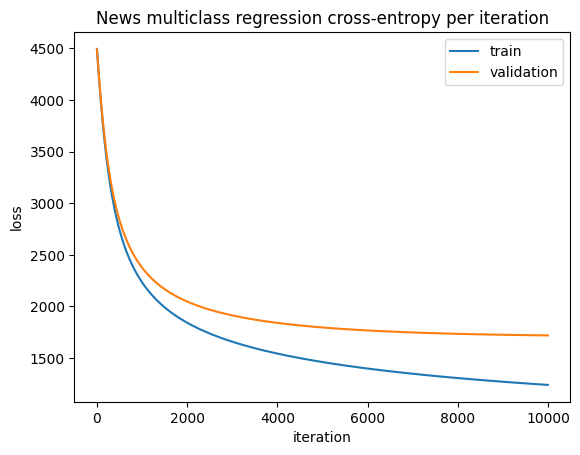

In [104]:
news_multi_reg = Multinomial_logistic(news_X_train.shape[1], len(news_y_labels))

def train_multi_reg():
  X_train, X_valid, y_train, y_valid = model_selection.train_test_split(news_X_train, news_y_train_onehot, test_size=0.5, random_state=42)
  news_multi_reg_losses_train, news_multi_reg_losses_valid = news_multi_reg.fit(X_train, y_train, X_valid, y_valid, learning_rate=0.001, niter=10000)
  return news_multi_reg_losses_train, news_multi_reg_losses_valid

def news_plot_ce(train_loss, valid_loss):
  plt.plot(train_loss, label='train')
  plt.plot(valid_loss, label='validation')
  plt.xlabel('iteration')
  plt.ylabel('loss')
  plt.title('News multiclass regression cross-entropy per iteration')
  plt.legend()

news_multi_reg_losses_train, news_multi_reg_losses_valid = train_multi_reg()
news_plot_ce(news_multi_reg_losses_train, news_multi_reg_losses_valid)

In the plot above, we observe that both the training and validation cross-entropy curves continue to decrease, showing no sign of overfitting.

##### Evaluating classification accuracy

In [105]:

news_multi_reg_pred_probs = news_multi_reg.predict(news_X_test)

k = 2
topk_classes = np.argsort(-news_multi_reg_pred_probs, axis=1)[:, :k]

# Check if the true label is within the top 3 predicted classes for each record
correct_predictions = np.array([true_label in top_labels for true_label, top_labels in zip(news_y_test, topk_classes)])

# Calculate the classification accuracy based on top 3 predictions
accuracy_topk = np.mean(correct_predictions)
print(f'Classification accuracy based on Top k predicted classes: {accuracy_topk * 100:.3f}%')
#news_multi_reg_pred = np.argmax(news_multi_reg_pred_probs, axis=1)
#print(f'Classification accuracy of Multiclass Regression: {np.mean(news_multi_reg_pred == news_y_test) * 100:.3f}%')

Classification accuracy based on Top k predicted classes: 87.443%


In [106]:
len(news_train.target_names)

8

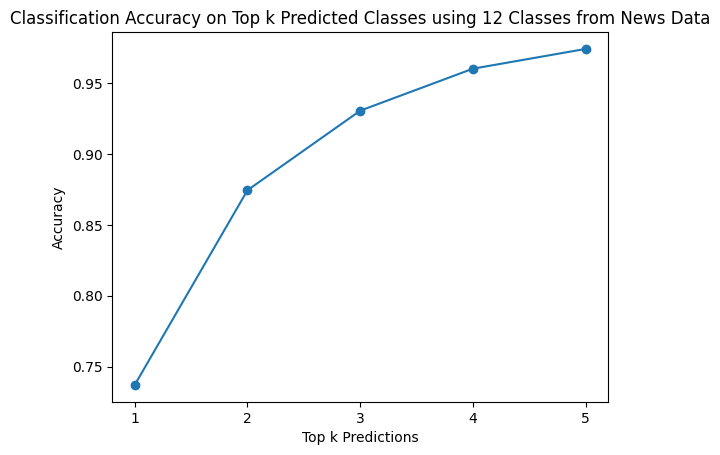

In [107]:
def plot_accuracy_on_k(news_y_test):
    k_values = [1, 2, 3, 4, 5]  # Different k values to consider
    accuracies = []

    for k in k_values:
        topk_classes = np.argsort(-news_multi_reg_pred_probs, axis=1)[:, :k]

        correct_predictions = np.array([true_label in top_labels for true_label, top_labels in zip(news_y_test, topk_classes)])
        accuracy_topk = np.mean(correct_predictions)
        accuracies.append(accuracy_topk)

    # Plot the accuracy based on different k values
    plt.figure()
    plt.plot(k_values, accuracies, marker='o')
    plt.xlabel('Top k Predictions')
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy on Top k Predicted Classes using 12 Classes from News Data')
    plt.xticks(np.arange(min(k_values), max(k_values)+1, 1))
    plt.show()

# Call the function with your data
plot_accuracy_on_k(news_y_test)

### Trial 2.4: 20 Classes

In [108]:

news_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
news_test = fetch_20newsgroups(subset='test')

In [109]:
# exclude words that appear in less than 0.5% of the news, and in more than 30% of the news during the vectorization
NEWS_MIN_DF = 0.0015
NEWS_MAX_DF = 0.3

In [110]:
vectorizer = TfidfVectorizer(min_df=NEWS_MIN_DF, max_df=NEWS_MAX_DF, stop_words='english')
vectors_train = vectorizer.fit_transform(news_train.data)
vectors_test = vectorizer.transform(news_test.data)
news_vocab = vectorizer.get_feature_names_out()
print(f'Class: {type(vectors_train)}', vectors_train.shape)
print(f'Class: {type(vectors_test)}', vectors_test.shape)
vectors_train

# print('How to get nonzero column indices in sparse matrix:\n', vectors_train[2].nonzero()[1])
# print(vectors_train[2, vectors_train[2].nonzero()[1][0]])
# print(news_vocab[vectors_train[2].nonzero()[1][0]])

Class: <class 'scipy.sparse._csr.csr_matrix'> (11314, 6886)
Class: <class 'scipy.sparse._csr.csr_matrix'> (7532, 6886)


<11314x6886 sparse matrix of type '<class 'numpy.float64'>'
	with 546129 stored elements in Compressed Sparse Row format>

In [111]:
c_vectorizer = CountVectorizer(min_df=NEWS_MIN_DF, max_df=NEWS_MAX_DF, stop_words='english')
c_vectors_train = c_vectorizer.fit_transform(news_train.data)
c_vectors_test = c_vectorizer.transform(news_test.data)
print(f'Class: {type(c_vectors_train)}', c_vectors_train.shape)
print(f'Class: {type(c_vectors_test)}', c_vectors_test.shape)
c_vectors_train

Class: <class 'scipy.sparse._csr.csr_matrix'> (11314, 6886)
Class: <class 'scipy.sparse._csr.csr_matrix'> (7532, 6886)


<11314x6886 sparse matrix of type '<class 'numpy.int64'>'
	with 546129 stored elements in Compressed Sparse Row format>

##### Filter out features

In [112]:
def news_count_occurrences(feat_vectors: csr_matrix):
  # count in how many rows did a feature appear
  feat_counts = {}
  for row in feat_vectors:
    for col in row.nonzero()[1]:
      if col in feat_counts:
        feat_counts[col] += 1
      else:
        feat_counts[col] = 1
  return feat_counts

In [113]:
news_feat_counts = news_count_occurrences(vectors_train)
print(len(news_feat_counts))
print_word_occurrences(news_feat_counts, news_vocab, feature=0)
#print_word_occurrences(news_feat_counts, news_vocab, word='gordon')

6886
The word "00" appears 243 times


In [114]:
# this shouldn't exclude any new values since we already filtered the features during vectorization: test if filter during vectorization is successful
NEWS_COUNT = len(news_train.target)
news_filtered_feats = set() # use set for O(1) lookups
news_excluded_feats = set()
for feat, count in news_feat_counts.items():
  if count < (NEWS_MIN_DF * NEWS_COUNT) or count > (NEWS_MAX_DF * NEWS_COUNT):
    news_excluded_feats.add(feat)
  else:
    news_filtered_feats.add(feat)

print(f'Number of excluded features: {len(news_excluded_feats)}')
print(f'Number of filtered features: {len(news_filtered_feats)}')
print(f'First 10 excluded words: {[news_vocab[feat] for feat in list(news_excluded_feats)[:10]]}')
print(f'Filtered words: {[news_vocab[feat] for feat in news_filtered_feats]}')

Number of excluded features: 0
Number of filtered features: 6886
First 10 excluded words: []
Filtered words: ['00', '000', '01', '02', '03', '04', '040', '05', '06', '07', '08', '09', '10', '100', '1000', '101', '102', '1024', '1024x768', '103', '104', '105', '106', '107', '108', '109', '10th', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '1200', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '1400', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '1500', '151', '152', '155', '158', '159', '16', '160', '161', '162', '163', '165', '169', '17', '170', '172', '175', '177', '179', '18', '180', '182', '184', '185', '19', '190', '1914', '1915', '1918', '1919', '192', '1920', '1948', '1958', '196', '1960', '1964', '1967', '1968', '1969', '1970', '1972', '1974', '1975', '1976', '1977', '1978', '1979', '198', '1980', '19

In [115]:
def filter_feature_vector(feat_vectors: csr_matrix, filtered_feats: set[int]):
  filter_columns = np.zeros(feat_vectors.shape[1])
  filter_columns[list(filtered_feats)] = 1 # set to 1 if feature is included
  filter_matrix = diags(filter_columns, dtype = feat_vectors.dtype) # create a diagonal matrix with the filter_columns as the diagonal
  # print(filter_matrix.A)
  res = feat_vectors @ filter_matrix # matrix multiplication
  res.eliminate_zeros() # remove zero entries
  return res

In [116]:
vectors_train_filtered = filter_feature_vector(vectors_train, news_filtered_feats)
c_vectors_train_filtered = filter_feature_vector(c_vectors_train, news_filtered_feats)
print(f'Class: {type(vectors_train_filtered)}', vectors_train_filtered.shape)
vectors_train_filtered

Class: <class 'scipy.sparse._csr.csr_matrix'> (11314, 6886)


<11314x6886 sparse matrix of type '<class 'numpy.float64'>'
	with 546129 stored elements in Compressed Sparse Row format>

##### Choose top features using mutual information

In [117]:
# unused function since sklearn.feature_selection.mutual_info_classif does the same thing but faster
def news_mi(feat_vectors: csr_matrix, y: np.ndarray, filtered_feats: set):
  mi_scores = {} # key: feature, value: mi
  for feat in filtered_feats:
    # X: value of feat in each row, y: ground truth of each row
    X = np.zeros(feat_vectors.shape[0])
    for id in range(feat_vectors.shape[0]):
      if feat in feat_vectors[id].nonzero()[1]: # if feature is present in the row of sparse matrix
        X[id] = feat_vectors[id, feat]
    mi_scores[feat] = mutual_info_score(y, X)
  return mi_scores

In [118]:
news_cat_mi_scores = []
news_cat_top_100 = []
for id, cat in enumerate(news_train.target_names):
  print(f'Category: {cat}')
  cat_target = (news_train.target == id).astype(int) # 1 if the category is the current category, 0 otherwise
  cat_mi_scores = mutual_info_classif(c_vectors_train_filtered, cat_target, random_state=42)
  cat_mi_scores = {feat: mi for feat, mi in enumerate(cat_mi_scores)}
  cat_top_100 = sorted(cat_mi_scores, key=cat_mi_scores.get, reverse=True)[:100]
  news_cat_mi_scores.append(cat_mi_scores)
  news_cat_top_100.append(cat_top_100)
  print(f'Top 100 words with the highest MI scores: {[news_vocab[feat] for feat in cat_top_100]}')
  print(f'MI scores: {[round(cat_mi_scores[feat], 5) for feat in cat_top_100]}')
  print()

Category: alt.atheism
Top 100 words with the highest MI scores: ['atheism', 'atheists', 'god', 'religion', 'atheist', 'islam', 'morality', 'religious', 'belief', 'bobby', 'islamic', 'bobbe', 'argument', 'queens', 'moral', 'ico', 'bronx', 'sank', 'manhattan', 'bible', 'objective', 'say', 'gods', 'tek', 'evidence', 'exist', 'species', 'blew', 'arguments', 'qur', 'people', 'alt', 'thanks', 'said', 'allah', 'claim', 'liar', 'statements', 'don', 'humans', 'believe', 'windows', 'motto', 'existence', 'punishment', 'deletion', 'sea', 'theist', 'religions', 'satan', 'evolution', 'exists', 'saying', '10', 'false', 'true', 'mom', 'natural', 'statement', 'contradiction', 'example', 'believer', 'contradictory', 'send', 'tells', 'definition', 'kent', 'society', 'logically', 'logic', 'mean', 'beliefs', 'think', 'life', 'consequences', 'agree', 'define', 'muslim', 'isn', 'vice', 'instance', 'christian', 'muslims', 'nature', 'does', 'mail', 'believing', 'program', 'accept', 'book', 'universe', '15', 'u

In [119]:
news_mi_feats = set()
for cat_top_100 in news_cat_top_100:
  for feat in cat_top_100[:80]:
    news_mi_feats.add(feat)

print([news_vocab[feat] for feat in news_mi_feats])
print(f'Total selected features: {len(news_mi_feats)}')

['00', '040', '10', '100', '145', '15', '150', '16', '1914', '1d', '1t', '20', '205', '230', '25', '250', '256', '2d', '30', '300', '33', '34', '386', '3d', '3l', '486', '486dx', '50', '512k', '5v', '610', '650', '6e', '730', '750', '837', '86', '950', '9v', '___', 'aaa', 'abiding', 'abs', 'accelerator', 'access', 'accident', 'actions', 'acts', 'acute', 'adaptec', 'adapter', 'adb', 'administration', 'advance', 'aerospace', 'agencies', 'agency', 'agents', 'agree', 'alarm', 'algorithm', 'algorithms', 'allah', 'allen', 'allergic', 'alomar', 'alt', 'altitude', 'ama', 'amendment', 'american', 'ames', 'amiga', 'ammunition', 'amp', 'amplifier', 'amps', 'analog', 'anecdotal', 'animation', 'antenna', 'anti', 'ap', 'apollo', 'apostles', 'apple', 'application', 'apps', 'arab', 'arabs', 'arf', 'argic', 'argument', 'arguments', 'armed', 'armenia', 'armenian', 'armenians', 'arms', 'army', 'arrogance', 'asking', 'assault', 'astro', 'astronomy', 'atf', 'atheism', 'atheist', 'atheists', 'athena', 'ati'

In [120]:
vectors_train_filtered = filter_feature_vector(vectors_train, news_mi_feats)
c_vectors_train_filtered = filter_feature_vector(c_vectors_train, news_mi_feats)
vectors_train_filtered

<11314x6886 sparse matrix of type '<class 'numpy.float64'>'
	with 165467 stored elements in Compressed Sparse Row format>

In [121]:
# we need to convert targets to one-hot encoding for fitting
def to_onehot(y, nClasses):
    return np.eye(nClasses)[y]

news_y_labels = news_train.target_names

news_X_train = vectors_train_filtered
news_y_train = news_train.target
news_y_train_onehot = to_onehot(news_y_train, len(news_y_labels))

news_X_test = vectors_test
news_y_test = news_test.target

##### Monitor cross-entropy

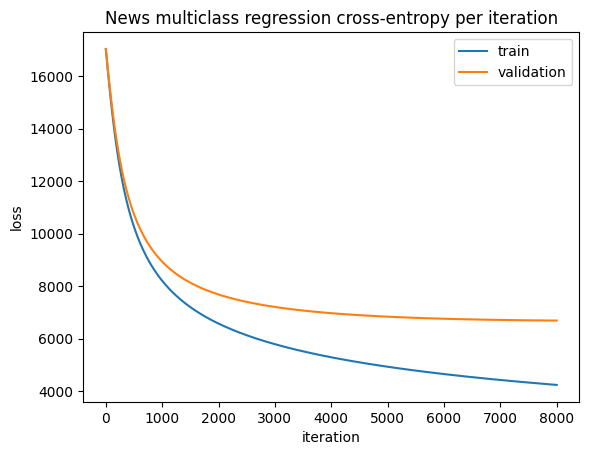

In [122]:
news_multi_reg = Multinomial_logistic(news_X_train.shape[1], len(news_y_labels))

def train_multi_reg():
  X_train, X_valid, y_train, y_valid = model_selection.train_test_split(news_X_train, news_y_train_onehot, test_size=0.5, random_state=42)
  news_multi_reg_losses_train, news_multi_reg_losses_valid = news_multi_reg.fit(X_train, y_train, X_valid, y_valid, learning_rate=0.001, niter=8000)
  return news_multi_reg_losses_train, news_multi_reg_losses_valid

def news_plot_ce(train_loss, valid_loss):
  plt.plot(train_loss, label='train')
  plt.plot(valid_loss, label='validation')
  plt.xlabel('iteration')
  plt.ylabel('loss')
  plt.title('News multiclass regression cross-entropy per iteration')
  plt.legend()

news_multi_reg_losses_train, news_multi_reg_losses_valid = train_multi_reg()
news_plot_ce(news_multi_reg_losses_train, news_multi_reg_losses_valid)

In the plot above, we observe some sign of overfitting.

##### Evaluating classification accuracy

In [123]:

news_multi_reg_pred_probs = news_multi_reg.predict(news_X_test)

k = 2
topk_classes = np.argsort(-news_multi_reg_pred_probs, axis=1)[:, :k]

# Check if the true label is within the top 3 predicted classes for each record
correct_predictions = np.array([true_label in top_labels for true_label, top_labels in zip(news_y_test, topk_classes)])

# Calculate the classification accuracy based on top 3 predictions
accuracy_topk = np.mean(correct_predictions)
print(f'Classification accuracy based on Top k predicted classes: {accuracy_topk * 100:.3f}%')
#news_multi_reg_pred = np.argmax(news_multi_reg_pred_probs, axis=1)
#print(f'Classification accuracy of Multiclass Regression: {np.mean(news_multi_reg_pred == news_y_test) * 100:.3f}%')

Classification accuracy based on Top k predicted classes: 82.515%


In [124]:
len(news_train.target_names)

20

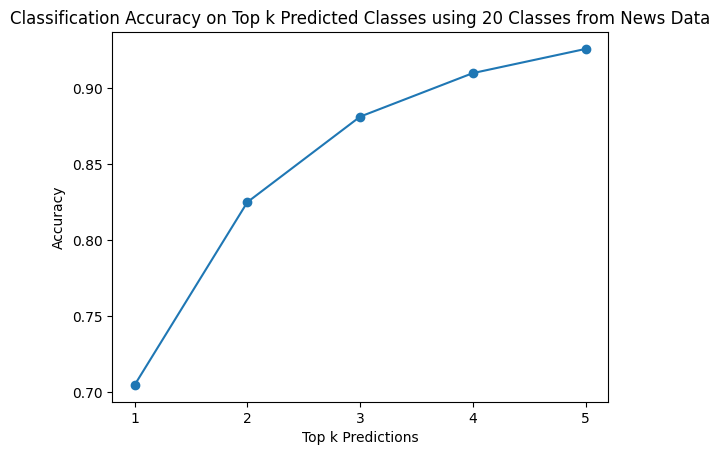

In [125]:
def plot_accuracy_on_k(news_y_test):
    k_values = [1, 2, 3, 4, 5]  # Different k values to consider
    accuracies = []

    for k in k_values:
        topk_classes = np.argsort(-news_multi_reg_pred_probs, axis=1)[:, :k]

        correct_predictions = np.array([true_label in top_labels for true_label, top_labels in zip(news_y_test, topk_classes)])
        accuracy_topk = np.mean(correct_predictions)
        accuracies.append(accuracy_topk)

    # Plot the accuracy based on different k values
    plt.figure()
    plt.plot(k_values, accuracies, marker='o')
    plt.xlabel('Top k Predictions')
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy on Top k Predicted Classes using 20 Classes from News Data')
    plt.xticks(np.arange(min(k_values), max(k_values)+1, 1))
    plt.show()

# Call the function with your data
plot_accuracy_on_k(news_y_test)